### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [2]:
import requests

# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [3]:
print(list(labels.items())[:5])

[(0, 'tench, Tinca tinca'), (1, 'goldfish, Carassius auratus'), (2, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'), (3, 'tiger shark, Galeocerdo cuvieri'), (4, 'hammerhead, hammerhead shark')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [4]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [7]:
import torch

dummy_x = torch.randn(5, 3, 299, 299)
model(dummy_x)

tensor([[-1.0688,  1.1368,  1.8578,  ..., -1.9721, -0.5215,  1.4144],
        [-1.0994,  0.9805,  1.5378,  ..., -2.2025, -0.1757,  1.8531],
        [-1.0158,  1.0891,  2.2583,  ..., -2.2822, -0.4586,  1.4388],
        [-1.1719,  0.9674,  1.5992,  ..., -2.0116, -0.3768,  1.8874],
        [-1.0634,  0.6466,  1.8040,  ..., -2.2357, -0.4025,  1.5213]],
       grad_fn=<AddmmBackward>)

### Predict class probabilities

In [8]:
# If using Colab
!mkdir sample_images
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg

mkdir: sample_images: File exists
--2019-12-07 12:16:33--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11607 (11K) [image/jpeg]
Saving to: ‘sample_images/albatross.jpg’

sample_images/albat 100%[===================>]  11.33K  --.-KB/s    in 0.003s  

2019-12-07 12:16:33 (3.78 MB/s) - ‘sample_images/albatross.jpg’ saved [11607/11607]



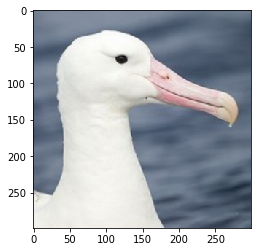

NameError: name 'torch' is not defined

In [10]:
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('sample_images/albatross.jpg'), (299, 299))
plt.imshow(img)
plt.show()


def transform_input(img):
    return torch.as_tensor(img.reshape([1, 299, 299, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)


def predict(img):
    img = transform_input(img)
    
    probs = torch.nn.functional.softmax(model(img), dim=-1)
    
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))
        

predict(img)

### Having fun with pre-trained nets

In [10]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

--2019-12-07 12:16:58--  http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Resolving cdn.com.do (cdn.com.do)... 104.26.4.67, 104.26.5.67
Connecting to cdn.com.do (cdn.com.do)|104.26.4.67|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg [following]
--2019-12-07 12:16:58--  https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Connecting to cdn.com.do (cdn.com.do)|104.26.4.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51048 (50K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  49.85K  --.-KB/s    in 0.004s  

2019-12-07 12:16:58 (12.6 MB/s) - ‘img.jpg’ saved [51048/51048]



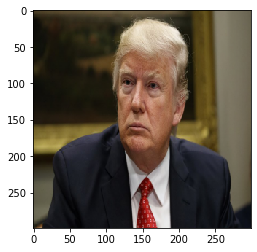

top-10 classes are: 
 [prob : class label]
0.6924 :	suit
0.0912 :	Windsor tie
0.0627 :	groom
0.0045 :	oboe
0.0040 :	academic gown
0.0034 :	Loafer
0.0032 :	wig
0.0028 :	Afghan hound
0.0027 :	bow tie


In [11]:
img = resize(plt.imread('img.jpg'), (299, 299))
plt.imshow(img)
plt.show()

predict(img)

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [12]:
!wget -nc https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip -n data.zip

--2019-12-07 12:17:19--  https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/ae1lq6dsfanse76/dogs_vs_cats.train.zip [following]
--2019-12-07 12:17:21--  https://www.dropbox.com/s/dl/ae1lq6dsfanse76/dogs_vs_cats.train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc374bc9d30570b7a53c13d54ce8.dl.dropboxusercontent.com/cd/0/get/Atz5QrNnAUGUurLcMy4Wv8A0A_9VNNEC41zfsDo-rhcvbCJxItCHku--cvdO_DYl_s8LHhqTAqZctkArggHyye46xUzkV6mZqsYtabpz04W8UA/file?dl=1# [following]
--2019-12-07 12:17:21--  https://uc374bc9d30570b7a53c13d54ce8.dl.dropboxusercontent.com/cd/0/get/Atz5QrNnAUGUurLcMy4Wv8A0A_9VNNEC41zfsDo-rhcvbCJxItCHku--cvdO_DYl_s8LHhqTAqZctkArggHyye46xUzkV6mZqsYtabpz04W8UA/file?dl=1
Resolvi

  inflating: train/cat.10201.jpg     
  inflating: train/cat.10202.jpg     
  inflating: train/cat.10203.jpg     
  inflating: train/cat.10204.jpg     
  inflating: train/cat.10205.jpg     
  inflating: train/cat.10206.jpg     
  inflating: train/cat.10207.jpg     
  inflating: train/cat.10208.jpg     
  inflating: train/cat.10209.jpg     
  inflating: train/cat.1021.jpg      
  inflating: train/cat.10210.jpg     
  inflating: train/cat.10211.jpg     
  inflating: train/cat.10212.jpg     
  inflating: train/cat.10213.jpg     
  inflating: train/cat.10214.jpg     
  inflating: train/cat.10215.jpg     
  inflating: train/cat.10216.jpg     
  inflating: train/cat.10217.jpg     
  inflating: train/cat.10218.jpg     
  inflating: train/cat.10219.jpg     
  inflating: train/cat.1022.jpg      
  inflating: train/cat.10220.jpg     
  inflating: train/cat.10221.jpg     
  inflating: train/cat.10222.jpg     
  inflating: train/cat.10223.jpg     
  inflating: train/cat.10224.jpg     
  inflating:

  inflating: train/cat.10398.jpg     
  inflating: train/cat.10399.jpg     
  inflating: train/cat.104.jpg       
  inflating: train/cat.1040.jpg      
  inflating: train/cat.10400.jpg     
  inflating: train/cat.10401.jpg     
  inflating: train/cat.10402.jpg     
  inflating: train/cat.10403.jpg     
  inflating: train/cat.10404.jpg     
  inflating: train/cat.10405.jpg     
  inflating: train/cat.10406.jpg     
  inflating: train/cat.10407.jpg     
  inflating: train/cat.10408.jpg     
  inflating: train/cat.10409.jpg     
  inflating: train/cat.1041.jpg      
  inflating: train/cat.10410.jpg     
  inflating: train/cat.10411.jpg     
  inflating: train/cat.10412.jpg     
  inflating: train/cat.10413.jpg     
  inflating: train/cat.10414.jpg     
  inflating: train/cat.10415.jpg     
  inflating: train/cat.10416.jpg     
  inflating: train/cat.10417.jpg     
  inflating: train/cat.10418.jpg     
  inflating: train/cat.10419.jpg     
  inflating: train/cat.1042.jpg      
  inflating:

  inflating: train/cat.10625.jpg     
  inflating: train/cat.10626.jpg     
  inflating: train/cat.10627.jpg     
  inflating: train/cat.10628.jpg     
  inflating: train/cat.10629.jpg     
  inflating: train/cat.1063.jpg      
  inflating: train/cat.10630.jpg     
  inflating: train/cat.10631.jpg     
  inflating: train/cat.10632.jpg     
  inflating: train/cat.10633.jpg     
  inflating: train/cat.10634.jpg     
  inflating: train/cat.10635.jpg     
  inflating: train/cat.10636.jpg     
  inflating: train/cat.10637.jpg     
  inflating: train/cat.10638.jpg     
  inflating: train/cat.10639.jpg     
  inflating: train/cat.1064.jpg      
  inflating: train/cat.10640.jpg     
  inflating: train/cat.10641.jpg     
  inflating: train/cat.10642.jpg     
  inflating: train/cat.10643.jpg     
  inflating: train/cat.10644.jpg     
  inflating: train/cat.10645.jpg     
  inflating: train/cat.10646.jpg     
  inflating: train/cat.10647.jpg     
  inflating: train/cat.10648.jpg     
  inflating:

  inflating: train/cat.10844.jpg     
  inflating: train/cat.10845.jpg     
  inflating: train/cat.10846.jpg     
  inflating: train/cat.10847.jpg     
  inflating: train/cat.10848.jpg     
  inflating: train/cat.10849.jpg     
  inflating: train/cat.1085.jpg      
  inflating: train/cat.10850.jpg     
  inflating: train/cat.10851.jpg     
  inflating: train/cat.10852.jpg     
  inflating: train/cat.10853.jpg     
  inflating: train/cat.10854.jpg     
  inflating: train/cat.10855.jpg     
  inflating: train/cat.10856.jpg     
  inflating: train/cat.10857.jpg     
  inflating: train/cat.10858.jpg     
  inflating: train/cat.10859.jpg     
  inflating: train/cat.1086.jpg      
  inflating: train/cat.10860.jpg     
  inflating: train/cat.10861.jpg     
  inflating: train/cat.10862.jpg     
  inflating: train/cat.10863.jpg     
  inflating: train/cat.10864.jpg     
  inflating: train/cat.10865.jpg     
  inflating: train/cat.10866.jpg     
  inflating: train/cat.10867.jpg     
  inflating:

  inflating: train/cat.11088.jpg     
  inflating: train/cat.11089.jpg     
  inflating: train/cat.1109.jpg      
  inflating: train/cat.11090.jpg     
  inflating: train/cat.11091.jpg     
  inflating: train/cat.11092.jpg     
  inflating: train/cat.11093.jpg     
  inflating: train/cat.11094.jpg     
  inflating: train/cat.11095.jpg     
  inflating: train/cat.11096.jpg     
  inflating: train/cat.11097.jpg     
  inflating: train/cat.11098.jpg     
  inflating: train/cat.11099.jpg     
  inflating: train/cat.111.jpg       
  inflating: train/cat.1110.jpg      
  inflating: train/cat.11100.jpg     
  inflating: train/cat.11101.jpg     
  inflating: train/cat.11102.jpg     
  inflating: train/cat.11103.jpg     
  inflating: train/cat.11104.jpg     
  inflating: train/cat.11105.jpg     
  inflating: train/cat.11106.jpg     
  inflating: train/cat.11107.jpg     
  inflating: train/cat.11108.jpg     
  inflating: train/cat.11109.jpg     
  inflating: train/cat.1111.jpg      
  inflating:

  inflating: train/cat.11290.jpg     
  inflating: train/cat.11291.jpg     
  inflating: train/cat.11292.jpg     
  inflating: train/cat.11293.jpg     
  inflating: train/cat.11294.jpg     
  inflating: train/cat.11295.jpg     
  inflating: train/cat.11296.jpg     
  inflating: train/cat.11297.jpg     
  inflating: train/cat.11298.jpg     
  inflating: train/cat.11299.jpg     
  inflating: train/cat.113.jpg       
  inflating: train/cat.1130.jpg      
  inflating: train/cat.11300.jpg     
  inflating: train/cat.11301.jpg     
  inflating: train/cat.11302.jpg     
  inflating: train/cat.11303.jpg     
  inflating: train/cat.11304.jpg     
  inflating: train/cat.11305.jpg     
  inflating: train/cat.11306.jpg     
  inflating: train/cat.11307.jpg     
  inflating: train/cat.11308.jpg     
  inflating: train/cat.11309.jpg     
  inflating: train/cat.1131.jpg      
  inflating: train/cat.11310.jpg     
  inflating: train/cat.11311.jpg     
  inflating: train/cat.11312.jpg     
  inflating:

  inflating: train/cat.1168.jpg      
  inflating: train/cat.11680.jpg     
  inflating: train/cat.11681.jpg     
  inflating: train/cat.11682.jpg     
  inflating: train/cat.11683.jpg     
  inflating: train/cat.11684.jpg     
  inflating: train/cat.11685.jpg     
  inflating: train/cat.11686.jpg     
  inflating: train/cat.11687.jpg     
  inflating: train/cat.11688.jpg     
  inflating: train/cat.11689.jpg     
  inflating: train/cat.1169.jpg      
  inflating: train/cat.11690.jpg     
  inflating: train/cat.11691.jpg     
  inflating: train/cat.11692.jpg     
  inflating: train/cat.11693.jpg     
  inflating: train/cat.11694.jpg     
  inflating: train/cat.11695.jpg     
  inflating: train/cat.11696.jpg     
  inflating: train/cat.11697.jpg     
  inflating: train/cat.11698.jpg     
  inflating: train/cat.11699.jpg     
  inflating: train/cat.117.jpg       
  inflating: train/cat.1170.jpg      
  inflating: train/cat.11700.jpg     
  inflating: train/cat.11701.jpg     
  inflating:

  inflating: train/cat.11925.jpg     
  inflating: train/cat.11926.jpg     
  inflating: train/cat.11927.jpg     
  inflating: train/cat.11928.jpg     
  inflating: train/cat.11929.jpg     
  inflating: train/cat.1193.jpg      
  inflating: train/cat.11930.jpg     
  inflating: train/cat.11931.jpg     
  inflating: train/cat.11932.jpg     
  inflating: train/cat.11933.jpg     
  inflating: train/cat.11934.jpg     
  inflating: train/cat.11935.jpg     
  inflating: train/cat.11936.jpg     
  inflating: train/cat.11937.jpg     
  inflating: train/cat.11938.jpg     
  inflating: train/cat.11939.jpg     
  inflating: train/cat.1194.jpg      
  inflating: train/cat.11940.jpg     
  inflating: train/cat.11941.jpg     
  inflating: train/cat.11942.jpg     
  inflating: train/cat.11943.jpg     
  inflating: train/cat.11944.jpg     
  inflating: train/cat.11945.jpg     
  inflating: train/cat.11946.jpg     
  inflating: train/cat.11947.jpg     
  inflating: train/cat.11948.jpg     
  inflating:

  inflating: train/cat.12175.jpg     
  inflating: train/cat.12176.jpg     
  inflating: train/cat.12177.jpg     
  inflating: train/cat.12178.jpg     
  inflating: train/cat.12179.jpg     
  inflating: train/cat.1218.jpg      
  inflating: train/cat.12180.jpg     
  inflating: train/cat.12181.jpg     
  inflating: train/cat.12182.jpg     
  inflating: train/cat.12183.jpg     
  inflating: train/cat.12184.jpg     
  inflating: train/cat.12185.jpg     
  inflating: train/cat.12186.jpg     
  inflating: train/cat.12187.jpg     
  inflating: train/cat.12188.jpg     
  inflating: train/cat.12189.jpg     
  inflating: train/cat.1219.jpg      
  inflating: train/cat.12190.jpg     
  inflating: train/cat.12191.jpg     
  inflating: train/cat.12192.jpg     
  inflating: train/cat.12193.jpg     
  inflating: train/cat.12194.jpg     
  inflating: train/cat.12195.jpg     
  inflating: train/cat.12196.jpg     
  inflating: train/cat.12197.jpg     
  inflating: train/cat.12198.jpg     
  inflating:

  inflating: train/cat.12374.jpg     
  inflating: train/cat.12375.jpg     
  inflating: train/cat.12376.jpg     
  inflating: train/cat.12377.jpg     
  inflating: train/cat.12378.jpg     
  inflating: train/cat.12379.jpg     
  inflating: train/cat.1238.jpg      
  inflating: train/cat.12380.jpg     
  inflating: train/cat.12381.jpg     
  inflating: train/cat.12382.jpg     
  inflating: train/cat.12383.jpg     
  inflating: train/cat.12384.jpg     
  inflating: train/cat.12385.jpg     
  inflating: train/cat.12386.jpg     
  inflating: train/cat.12387.jpg     
  inflating: train/cat.12388.jpg     
  inflating: train/cat.12389.jpg     
  inflating: train/cat.1239.jpg      
  inflating: train/cat.12390.jpg     
  inflating: train/cat.12391.jpg     
  inflating: train/cat.12392.jpg     
  inflating: train/cat.12393.jpg     
  inflating: train/cat.12394.jpg     
  inflating: train/cat.12395.jpg     
  inflating: train/cat.12396.jpg     
  inflating: train/cat.12397.jpg     
  inflating:

  inflating: train/cat.1372.jpg      
  inflating: train/cat.1373.jpg      
  inflating: train/cat.1374.jpg      
  inflating: train/cat.1375.jpg      
  inflating: train/cat.1376.jpg      
  inflating: train/cat.1377.jpg      
  inflating: train/cat.1378.jpg      
  inflating: train/cat.1379.jpg      
  inflating: train/cat.138.jpg       
  inflating: train/cat.1380.jpg      
  inflating: train/cat.1381.jpg      
  inflating: train/cat.1382.jpg      
  inflating: train/cat.1383.jpg      
  inflating: train/cat.1384.jpg      
  inflating: train/cat.1385.jpg      
  inflating: train/cat.1386.jpg      
  inflating: train/cat.1387.jpg      
  inflating: train/cat.1388.jpg      
  inflating: train/cat.1389.jpg      
  inflating: train/cat.139.jpg       
  inflating: train/cat.1390.jpg      
  inflating: train/cat.1391.jpg      
  inflating: train/cat.1392.jpg      
  inflating: train/cat.1393.jpg      
  inflating: train/cat.1394.jpg      
  inflating: train/cat.1395.jpg      
  inflating:

  inflating: train/cat.1577.jpg      
  inflating: train/cat.1578.jpg      
  inflating: train/cat.1579.jpg      
  inflating: train/cat.158.jpg       
  inflating: train/cat.1580.jpg      
  inflating: train/cat.1581.jpg      
  inflating: train/cat.1582.jpg      
  inflating: train/cat.1583.jpg      
  inflating: train/cat.1584.jpg      
  inflating: train/cat.1585.jpg      
  inflating: train/cat.1586.jpg      
  inflating: train/cat.1587.jpg      
  inflating: train/cat.1588.jpg      
  inflating: train/cat.1589.jpg      
  inflating: train/cat.159.jpg       
  inflating: train/cat.1590.jpg      
  inflating: train/cat.1591.jpg      
  inflating: train/cat.1592.jpg      
  inflating: train/cat.1593.jpg      
  inflating: train/cat.1594.jpg      
  inflating: train/cat.1595.jpg      
  inflating: train/cat.1596.jpg      
  inflating: train/cat.1597.jpg      
  inflating: train/cat.1598.jpg      
  inflating: train/cat.1599.jpg      
  inflating: train/cat.16.jpg        
  inflating:

  inflating: train/cat.1784.jpg      
  inflating: train/cat.1785.jpg      
  inflating: train/cat.1786.jpg      
  inflating: train/cat.1787.jpg      
  inflating: train/cat.1788.jpg      
  inflating: train/cat.1789.jpg      
  inflating: train/cat.179.jpg       
  inflating: train/cat.1790.jpg      
  inflating: train/cat.1791.jpg      
  inflating: train/cat.1792.jpg      
  inflating: train/cat.1793.jpg      
  inflating: train/cat.1794.jpg      
  inflating: train/cat.1795.jpg      
  inflating: train/cat.1796.jpg      
  inflating: train/cat.1797.jpg      
  inflating: train/cat.1798.jpg      
  inflating: train/cat.1799.jpg      
  inflating: train/cat.18.jpg        
  inflating: train/cat.180.jpg       
  inflating: train/cat.1800.jpg      
  inflating: train/cat.1801.jpg      
  inflating: train/cat.1802.jpg      
  inflating: train/cat.1803.jpg      
  inflating: train/cat.1804.jpg      
  inflating: train/cat.1805.jpg      
  inflating: train/cat.1806.jpg      
  inflating:

  inflating: train/cat.1983.jpg      
  inflating: train/cat.1984.jpg      
  inflating: train/cat.1985.jpg      
  inflating: train/cat.1986.jpg      
  inflating: train/cat.1987.jpg      
  inflating: train/cat.1988.jpg      
  inflating: train/cat.1989.jpg      
  inflating: train/cat.199.jpg       
  inflating: train/cat.1990.jpg      
  inflating: train/cat.1991.jpg      
  inflating: train/cat.1992.jpg      
  inflating: train/cat.1993.jpg      
  inflating: train/cat.1994.jpg      
  inflating: train/cat.1995.jpg      
  inflating: train/cat.1996.jpg      
  inflating: train/cat.1997.jpg      
  inflating: train/cat.1998.jpg      
  inflating: train/cat.1999.jpg      
  inflating: train/cat.2.jpg         
  inflating: train/cat.20.jpg        
  inflating: train/cat.200.jpg       
  inflating: train/cat.2000.jpg      
  inflating: train/cat.2001.jpg      
  inflating: train/cat.2002.jpg      
  inflating: train/cat.2003.jpg      
  inflating: train/cat.2004.jpg      
  inflating:

  inflating: train/cat.2241.jpg      
  inflating: train/cat.2242.jpg      
  inflating: train/cat.2243.jpg      
  inflating: train/cat.2244.jpg      
  inflating: train/cat.2245.jpg      
  inflating: train/cat.2246.jpg      
  inflating: train/cat.2247.jpg      
  inflating: train/cat.2248.jpg      
  inflating: train/cat.2249.jpg      
  inflating: train/cat.225.jpg       
  inflating: train/cat.2250.jpg      
  inflating: train/cat.2251.jpg      
  inflating: train/cat.2252.jpg      
  inflating: train/cat.2253.jpg      
  inflating: train/cat.2254.jpg      
  inflating: train/cat.2255.jpg      
  inflating: train/cat.2256.jpg      
  inflating: train/cat.2257.jpg      
  inflating: train/cat.2258.jpg      
  inflating: train/cat.2259.jpg      
  inflating: train/cat.226.jpg       
  inflating: train/cat.2260.jpg      
  inflating: train/cat.2261.jpg      
  inflating: train/cat.2262.jpg      
  inflating: train/cat.2263.jpg      
  inflating: train/cat.2264.jpg      
  inflating:

  inflating: train/cat.2690.jpg      
  inflating: train/cat.2691.jpg      
  inflating: train/cat.2692.jpg      
  inflating: train/cat.2693.jpg      
  inflating: train/cat.2694.jpg      
  inflating: train/cat.2695.jpg      
  inflating: train/cat.2696.jpg      
  inflating: train/cat.2697.jpg      
  inflating: train/cat.2698.jpg      
  inflating: train/cat.2699.jpg      
  inflating: train/cat.27.jpg        
  inflating: train/cat.270.jpg       
  inflating: train/cat.2700.jpg      
  inflating: train/cat.2701.jpg      
  inflating: train/cat.2702.jpg      
  inflating: train/cat.2703.jpg      
  inflating: train/cat.2704.jpg      
  inflating: train/cat.2705.jpg      
  inflating: train/cat.2706.jpg      
  inflating: train/cat.2707.jpg      
  inflating: train/cat.2708.jpg      
  inflating: train/cat.2709.jpg      
  inflating: train/cat.271.jpg       
  inflating: train/cat.2710.jpg      
  inflating: train/cat.2711.jpg      
  inflating: train/cat.2712.jpg      
  inflating:

  inflating: train/cat.2949.jpg      
  inflating: train/cat.295.jpg       
  inflating: train/cat.2950.jpg      
  inflating: train/cat.2951.jpg      
  inflating: train/cat.2952.jpg      
  inflating: train/cat.2953.jpg      
  inflating: train/cat.2954.jpg      
  inflating: train/cat.2955.jpg      
  inflating: train/cat.2956.jpg      
  inflating: train/cat.2957.jpg      
  inflating: train/cat.2958.jpg      
  inflating: train/cat.2959.jpg      
  inflating: train/cat.296.jpg       
  inflating: train/cat.2960.jpg      
  inflating: train/cat.2961.jpg      
  inflating: train/cat.2962.jpg      
  inflating: train/cat.2963.jpg      
  inflating: train/cat.2964.jpg      
  inflating: train/cat.2965.jpg      
  inflating: train/cat.2966.jpg      
  inflating: train/cat.2967.jpg      
  inflating: train/cat.2968.jpg      
  inflating: train/cat.2969.jpg      
  inflating: train/cat.297.jpg       
  inflating: train/cat.2970.jpg      
  inflating: train/cat.2971.jpg      
  inflating:

  inflating: train/cat.3210.jpg      
  inflating: train/cat.3211.jpg      
  inflating: train/cat.3212.jpg      
  inflating: train/cat.3213.jpg      
  inflating: train/cat.3214.jpg      
  inflating: train/cat.3215.jpg      
  inflating: train/cat.3216.jpg      
  inflating: train/cat.3217.jpg      
  inflating: train/cat.3218.jpg      
  inflating: train/cat.3219.jpg      
  inflating: train/cat.322.jpg       
  inflating: train/cat.3220.jpg      
  inflating: train/cat.3221.jpg      
  inflating: train/cat.3222.jpg      
  inflating: train/cat.3223.jpg      
  inflating: train/cat.3224.jpg      
  inflating: train/cat.3225.jpg      
  inflating: train/cat.3226.jpg      
  inflating: train/cat.3227.jpg      
  inflating: train/cat.3228.jpg      
  inflating: train/cat.3229.jpg      
  inflating: train/cat.323.jpg       
  inflating: train/cat.3230.jpg      
  inflating: train/cat.3231.jpg      
  inflating: train/cat.3232.jpg      
  inflating: train/cat.3233.jpg      
  inflating:

  inflating: train/cat.3420.jpg      
  inflating: train/cat.3421.jpg      
  inflating: train/cat.3422.jpg      
  inflating: train/cat.3423.jpg      
  inflating: train/cat.3424.jpg      
  inflating: train/cat.3425.jpg      
  inflating: train/cat.3426.jpg      
  inflating: train/cat.3427.jpg      
  inflating: train/cat.3428.jpg      
  inflating: train/cat.3429.jpg      
  inflating: train/cat.343.jpg       
  inflating: train/cat.3430.jpg      
  inflating: train/cat.3431.jpg      
  inflating: train/cat.3432.jpg      
  inflating: train/cat.3433.jpg      
  inflating: train/cat.3434.jpg      
  inflating: train/cat.3435.jpg      
  inflating: train/cat.3436.jpg      
  inflating: train/cat.3437.jpg      
  inflating: train/cat.3438.jpg      
  inflating: train/cat.3439.jpg      
  inflating: train/cat.344.jpg       
  inflating: train/cat.3440.jpg      
  inflating: train/cat.3441.jpg      
  inflating: train/cat.3442.jpg      
  inflating: train/cat.3443.jpg      
  inflating:

  inflating: train/cat.3673.jpg      
  inflating: train/cat.3674.jpg      
  inflating: train/cat.3675.jpg      
  inflating: train/cat.3676.jpg      
  inflating: train/cat.3677.jpg      
  inflating: train/cat.3678.jpg      
  inflating: train/cat.3679.jpg      
  inflating: train/cat.368.jpg       
  inflating: train/cat.3680.jpg      
  inflating: train/cat.3681.jpg      
  inflating: train/cat.3682.jpg      
  inflating: train/cat.3683.jpg      
  inflating: train/cat.3684.jpg      
  inflating: train/cat.3685.jpg      
  inflating: train/cat.3686.jpg      
  inflating: train/cat.3687.jpg      
  inflating: train/cat.3688.jpg      
  inflating: train/cat.3689.jpg      
  inflating: train/cat.369.jpg       
  inflating: train/cat.3690.jpg      
  inflating: train/cat.3691.jpg      
  inflating: train/cat.3692.jpg      
  inflating: train/cat.3693.jpg      
  inflating: train/cat.3694.jpg      
  inflating: train/cat.3695.jpg      
  inflating: train/cat.3696.jpg      
  inflating:

  inflating: train/cat.3879.jpg      
  inflating: train/cat.388.jpg       
  inflating: train/cat.3880.jpg      
  inflating: train/cat.3881.jpg      
  inflating: train/cat.3882.jpg      
  inflating: train/cat.3883.jpg      
  inflating: train/cat.3884.jpg      
  inflating: train/cat.3885.jpg      
  inflating: train/cat.3886.jpg      
  inflating: train/cat.3887.jpg      
  inflating: train/cat.3888.jpg      
  inflating: train/cat.3889.jpg      
  inflating: train/cat.389.jpg       
  inflating: train/cat.3890.jpg      
  inflating: train/cat.3891.jpg      
  inflating: train/cat.3892.jpg      
  inflating: train/cat.3893.jpg      
  inflating: train/cat.3894.jpg      
  inflating: train/cat.3895.jpg      
  inflating: train/cat.3896.jpg      
  inflating: train/cat.3897.jpg      
  inflating: train/cat.3898.jpg      
  inflating: train/cat.3899.jpg      
  inflating: train/cat.39.jpg        
  inflating: train/cat.390.jpg       
  inflating: train/cat.3900.jpg      
  inflating:

  inflating: train/cat.4132.jpg      
  inflating: train/cat.4133.jpg      
  inflating: train/cat.4134.jpg      
  inflating: train/cat.4135.jpg      
  inflating: train/cat.4136.jpg      
  inflating: train/cat.4137.jpg      
  inflating: train/cat.4138.jpg      
  inflating: train/cat.4139.jpg      
  inflating: train/cat.414.jpg       
  inflating: train/cat.4140.jpg      
  inflating: train/cat.4141.jpg      
  inflating: train/cat.4142.jpg      
  inflating: train/cat.4143.jpg      
  inflating: train/cat.4144.jpg      
  inflating: train/cat.4145.jpg      
  inflating: train/cat.4146.jpg      
  inflating: train/cat.4147.jpg      
  inflating: train/cat.4148.jpg      
  inflating: train/cat.4149.jpg      
  inflating: train/cat.415.jpg       
  inflating: train/cat.4150.jpg      
  inflating: train/cat.4151.jpg      
  inflating: train/cat.4152.jpg      
  inflating: train/cat.4153.jpg      
  inflating: train/cat.4154.jpg      
  inflating: train/cat.4155.jpg      
  inflating:

  inflating: train/cat.4392.jpg      
  inflating: train/cat.4393.jpg      
  inflating: train/cat.4394.jpg      
  inflating: train/cat.4395.jpg      
  inflating: train/cat.4396.jpg      
  inflating: train/cat.4397.jpg      
  inflating: train/cat.4398.jpg      
  inflating: train/cat.4399.jpg      
  inflating: train/cat.44.jpg        
  inflating: train/cat.440.jpg       
  inflating: train/cat.4400.jpg      
  inflating: train/cat.4401.jpg      
  inflating: train/cat.4402.jpg      
  inflating: train/cat.4403.jpg      
  inflating: train/cat.4404.jpg      
  inflating: train/cat.4405.jpg      
  inflating: train/cat.4406.jpg      
  inflating: train/cat.4407.jpg      
  inflating: train/cat.4408.jpg      
  inflating: train/cat.4409.jpg      
  inflating: train/cat.441.jpg       
  inflating: train/cat.4410.jpg      
  inflating: train/cat.4411.jpg      
  inflating: train/cat.4412.jpg      
  inflating: train/cat.4413.jpg      
  inflating: train/cat.4414.jpg      
  inflating:

  inflating: train/cat.4627.jpg      
  inflating: train/cat.4628.jpg      
  inflating: train/cat.4629.jpg      
  inflating: train/cat.463.jpg       
  inflating: train/cat.4630.jpg      
  inflating: train/cat.4631.jpg      
  inflating: train/cat.4632.jpg      
  inflating: train/cat.4633.jpg      
  inflating: train/cat.4634.jpg      
  inflating: train/cat.4635.jpg      
  inflating: train/cat.4636.jpg      
  inflating: train/cat.4637.jpg      
  inflating: train/cat.4638.jpg      
  inflating: train/cat.4639.jpg      
  inflating: train/cat.464.jpg       
  inflating: train/cat.4640.jpg      
  inflating: train/cat.4641.jpg      
  inflating: train/cat.4642.jpg      
  inflating: train/cat.4643.jpg      
  inflating: train/cat.4644.jpg      
  inflating: train/cat.4645.jpg      
  inflating: train/cat.4646.jpg      
  inflating: train/cat.4647.jpg      
  inflating: train/cat.4648.jpg      
  inflating: train/cat.4649.jpg      
  inflating: train/cat.465.jpg       
  inflating:

  inflating: train/cat.4839.jpg      
  inflating: train/cat.484.jpg       
  inflating: train/cat.4840.jpg      
  inflating: train/cat.4841.jpg      
  inflating: train/cat.4842.jpg      
  inflating: train/cat.4843.jpg      
  inflating: train/cat.4844.jpg      
  inflating: train/cat.4845.jpg      
  inflating: train/cat.4846.jpg      
  inflating: train/cat.4847.jpg      
  inflating: train/cat.4848.jpg      
  inflating: train/cat.4849.jpg      
  inflating: train/cat.485.jpg       
  inflating: train/cat.4850.jpg      
  inflating: train/cat.4851.jpg      
  inflating: train/cat.4852.jpg      
  inflating: train/cat.4853.jpg      
  inflating: train/cat.4854.jpg      
  inflating: train/cat.4855.jpg      
  inflating: train/cat.4856.jpg      
  inflating: train/cat.4857.jpg      
  inflating: train/cat.4858.jpg      
  inflating: train/cat.4859.jpg      
  inflating: train/cat.486.jpg       
  inflating: train/cat.4860.jpg      
  inflating: train/cat.4861.jpg      
  inflating:

  inflating: train/cat.5038.jpg      
  inflating: train/cat.5039.jpg      
  inflating: train/cat.504.jpg       
  inflating: train/cat.5040.jpg      
  inflating: train/cat.5041.jpg      
  inflating: train/cat.5042.jpg      
  inflating: train/cat.5043.jpg      
  inflating: train/cat.5044.jpg      
  inflating: train/cat.5045.jpg      
  inflating: train/cat.5046.jpg      
  inflating: train/cat.5047.jpg      
  inflating: train/cat.5048.jpg      
  inflating: train/cat.5049.jpg      
  inflating: train/cat.505.jpg       
  inflating: train/cat.5050.jpg      
  inflating: train/cat.5051.jpg      
  inflating: train/cat.5052.jpg      
  inflating: train/cat.5053.jpg      
  inflating: train/cat.5054.jpg      
  inflating: train/cat.5055.jpg      
  inflating: train/cat.5056.jpg      
  inflating: train/cat.5057.jpg      
  inflating: train/cat.5058.jpg      
  inflating: train/cat.5059.jpg      
  inflating: train/cat.506.jpg       
  inflating: train/cat.5060.jpg      
  inflating:

  inflating: train/cat.5296.jpg      
  inflating: train/cat.5297.jpg      
  inflating: train/cat.5298.jpg      
  inflating: train/cat.5299.jpg      
  inflating: train/cat.53.jpg        
  inflating: train/cat.530.jpg       
  inflating: train/cat.5300.jpg      
  inflating: train/cat.5301.jpg      
  inflating: train/cat.5302.jpg      
  inflating: train/cat.5303.jpg      
  inflating: train/cat.5304.jpg      
  inflating: train/cat.5305.jpg      
  inflating: train/cat.5306.jpg      
  inflating: train/cat.5307.jpg      
  inflating: train/cat.5308.jpg      
  inflating: train/cat.5309.jpg      
  inflating: train/cat.531.jpg       
  inflating: train/cat.5310.jpg      
  inflating: train/cat.5311.jpg      
  inflating: train/cat.5312.jpg      
  inflating: train/cat.5313.jpg      
  inflating: train/cat.5314.jpg      
  inflating: train/cat.5315.jpg      
  inflating: train/cat.5316.jpg      
  inflating: train/cat.5317.jpg      
  inflating: train/cat.5318.jpg      
  inflating:

  inflating: train/cat.55.jpg        
  inflating: train/cat.550.jpg       
  inflating: train/cat.5500.jpg      
  inflating: train/cat.5501.jpg      
  inflating: train/cat.5502.jpg      
  inflating: train/cat.5503.jpg      
  inflating: train/cat.5504.jpg      
  inflating: train/cat.5505.jpg      
  inflating: train/cat.5506.jpg      
  inflating: train/cat.5507.jpg      
  inflating: train/cat.5508.jpg      
  inflating: train/cat.5509.jpg      
  inflating: train/cat.551.jpg       
  inflating: train/cat.5510.jpg      
  inflating: train/cat.5511.jpg      
  inflating: train/cat.5512.jpg      
  inflating: train/cat.5513.jpg      
  inflating: train/cat.5514.jpg      
  inflating: train/cat.5515.jpg      
  inflating: train/cat.5516.jpg      
  inflating: train/cat.5517.jpg      
  inflating: train/cat.5518.jpg      
  inflating: train/cat.5519.jpg      
  inflating: train/cat.552.jpg       
  inflating: train/cat.5520.jpg      
  inflating: train/cat.5521.jpg      
  inflating:

  inflating: train/cat.5696.jpg      
  inflating: train/cat.5697.jpg      
  inflating: train/cat.5698.jpg      
  inflating: train/cat.5699.jpg      
  inflating: train/cat.57.jpg        
  inflating: train/cat.570.jpg       
  inflating: train/cat.5700.jpg      
  inflating: train/cat.5701.jpg      
  inflating: train/cat.5702.jpg      
  inflating: train/cat.5703.jpg      
  inflating: train/cat.5704.jpg      
  inflating: train/cat.5705.jpg      
  inflating: train/cat.5706.jpg      
  inflating: train/cat.5707.jpg      
  inflating: train/cat.5708.jpg      
  inflating: train/cat.5709.jpg      
  inflating: train/cat.571.jpg       
  inflating: train/cat.5710.jpg      
  inflating: train/cat.5711.jpg      
  inflating: train/cat.5712.jpg      
  inflating: train/cat.5713.jpg      
  inflating: train/cat.5714.jpg      
  inflating: train/cat.5715.jpg      
  inflating: train/cat.5716.jpg      
  inflating: train/cat.5717.jpg      
  inflating: train/cat.5718.jpg      
  inflating:

  inflating: train/cat.5903.jpg      
  inflating: train/cat.5904.jpg      
  inflating: train/cat.5905.jpg      
  inflating: train/cat.5906.jpg      
  inflating: train/cat.5907.jpg      
  inflating: train/cat.5908.jpg      
  inflating: train/cat.5909.jpg      
  inflating: train/cat.591.jpg       
  inflating: train/cat.5910.jpg      
  inflating: train/cat.5911.jpg      
  inflating: train/cat.5912.jpg      
  inflating: train/cat.5913.jpg      
  inflating: train/cat.5914.jpg      
  inflating: train/cat.5915.jpg      
  inflating: train/cat.5916.jpg      
  inflating: train/cat.5917.jpg      
  inflating: train/cat.5918.jpg      
  inflating: train/cat.5919.jpg      
  inflating: train/cat.592.jpg       
  inflating: train/cat.5920.jpg      
  inflating: train/cat.5921.jpg      
  inflating: train/cat.5922.jpg      
  inflating: train/cat.5923.jpg      
  inflating: train/cat.5924.jpg      
  inflating: train/cat.5925.jpg      
  inflating: train/cat.5926.jpg      
  inflating:

  inflating: train/cat.6109.jpg      
  inflating: train/cat.611.jpg       
  inflating: train/cat.6110.jpg      
  inflating: train/cat.6111.jpg      
  inflating: train/cat.6112.jpg      
  inflating: train/cat.6113.jpg      
  inflating: train/cat.6114.jpg      
  inflating: train/cat.6115.jpg      
  inflating: train/cat.6116.jpg      
  inflating: train/cat.6117.jpg      
  inflating: train/cat.6118.jpg      
  inflating: train/cat.6119.jpg      
  inflating: train/cat.612.jpg       
  inflating: train/cat.6120.jpg      
  inflating: train/cat.6121.jpg      
  inflating: train/cat.6122.jpg      
  inflating: train/cat.6123.jpg      
  inflating: train/cat.6124.jpg      
  inflating: train/cat.6125.jpg      
  inflating: train/cat.6126.jpg      
  inflating: train/cat.6127.jpg      
  inflating: train/cat.6128.jpg      
  inflating: train/cat.6129.jpg      
  inflating: train/cat.613.jpg       
  inflating: train/cat.6130.jpg      
  inflating: train/cat.6131.jpg      
  inflating:

  inflating: train/cat.6369.jpg      
  inflating: train/cat.637.jpg       
  inflating: train/cat.6370.jpg      
  inflating: train/cat.6371.jpg      
  inflating: train/cat.6372.jpg      
  inflating: train/cat.6373.jpg      
  inflating: train/cat.6374.jpg      
  inflating: train/cat.6375.jpg      
  inflating: train/cat.6376.jpg      
  inflating: train/cat.6377.jpg      
  inflating: train/cat.6378.jpg      
  inflating: train/cat.6379.jpg      
  inflating: train/cat.638.jpg       
  inflating: train/cat.6380.jpg      
  inflating: train/cat.6381.jpg      
  inflating: train/cat.6382.jpg      
  inflating: train/cat.6383.jpg      
  inflating: train/cat.6384.jpg      
  inflating: train/cat.6385.jpg      
  inflating: train/cat.6386.jpg      
  inflating: train/cat.6387.jpg      
  inflating: train/cat.6388.jpg      
  inflating: train/cat.6389.jpg      
  inflating: train/cat.639.jpg       
  inflating: train/cat.6390.jpg      
  inflating: train/cat.6391.jpg      
  inflating:

  inflating: train/cat.6594.jpg      
  inflating: train/cat.6595.jpg      
  inflating: train/cat.6596.jpg      
  inflating: train/cat.6597.jpg      
  inflating: train/cat.6598.jpg      
  inflating: train/cat.6599.jpg      
  inflating: train/cat.66.jpg        
  inflating: train/cat.660.jpg       
  inflating: train/cat.6600.jpg      
  inflating: train/cat.6601.jpg      
  inflating: train/cat.6602.jpg      
  inflating: train/cat.6603.jpg      
  inflating: train/cat.6604.jpg      
  inflating: train/cat.6605.jpg      
  inflating: train/cat.6606.jpg      
  inflating: train/cat.6607.jpg      
  inflating: train/cat.6608.jpg      
  inflating: train/cat.6609.jpg      
  inflating: train/cat.661.jpg       
  inflating: train/cat.6610.jpg      
  inflating: train/cat.6611.jpg      
  inflating: train/cat.6612.jpg      
  inflating: train/cat.6613.jpg      
  inflating: train/cat.6614.jpg      
  inflating: train/cat.6615.jpg      
  inflating: train/cat.6616.jpg      
  inflating:

  inflating: train/cat.6801.jpg      
  inflating: train/cat.6802.jpg      
  inflating: train/cat.6803.jpg      
  inflating: train/cat.6804.jpg      
  inflating: train/cat.6805.jpg      
  inflating: train/cat.6806.jpg      
  inflating: train/cat.6807.jpg      
  inflating: train/cat.6808.jpg      
  inflating: train/cat.6809.jpg      
  inflating: train/cat.681.jpg       
  inflating: train/cat.6810.jpg      
  inflating: train/cat.6811.jpg      
  inflating: train/cat.6812.jpg      
  inflating: train/cat.6813.jpg      
  inflating: train/cat.6814.jpg      
  inflating: train/cat.6815.jpg      
  inflating: train/cat.6816.jpg      
  inflating: train/cat.6817.jpg      
  inflating: train/cat.6818.jpg      
  inflating: train/cat.6819.jpg      
  inflating: train/cat.682.jpg       
  inflating: train/cat.6820.jpg      
  inflating: train/cat.6821.jpg      
  inflating: train/cat.6822.jpg      
  inflating: train/cat.6823.jpg      
  inflating: train/cat.6824.jpg      
  inflating:

  inflating: train/cat.701.jpg       
  inflating: train/cat.7010.jpg      
  inflating: train/cat.7011.jpg      
  inflating: train/cat.7012.jpg      
  inflating: train/cat.7013.jpg      
  inflating: train/cat.7014.jpg      
  inflating: train/cat.7015.jpg      
  inflating: train/cat.7016.jpg      
  inflating: train/cat.7017.jpg      
  inflating: train/cat.7018.jpg      
  inflating: train/cat.7019.jpg      
  inflating: train/cat.702.jpg       
  inflating: train/cat.7020.jpg      
  inflating: train/cat.7021.jpg      
  inflating: train/cat.7022.jpg      
  inflating: train/cat.7023.jpg      
  inflating: train/cat.7024.jpg      
  inflating: train/cat.7025.jpg      
  inflating: train/cat.7026.jpg      
  inflating: train/cat.7027.jpg      
  inflating: train/cat.7028.jpg      
  inflating: train/cat.7029.jpg      
  inflating: train/cat.703.jpg       
  inflating: train/cat.7030.jpg      
  inflating: train/cat.7031.jpg      
  inflating: train/cat.7032.jpg      
  inflating:

  inflating: train/cat.7272.jpg      
  inflating: train/cat.7273.jpg      
  inflating: train/cat.7274.jpg      
  inflating: train/cat.7275.jpg      
  inflating: train/cat.7276.jpg      
  inflating: train/cat.7277.jpg      
  inflating: train/cat.7278.jpg      
  inflating: train/cat.7279.jpg      
  inflating: train/cat.728.jpg       
  inflating: train/cat.7280.jpg      
  inflating: train/cat.7281.jpg      
  inflating: train/cat.7282.jpg      
  inflating: train/cat.7283.jpg      
  inflating: train/cat.7284.jpg      
  inflating: train/cat.7285.jpg      
  inflating: train/cat.7286.jpg      
  inflating: train/cat.7287.jpg      
  inflating: train/cat.7288.jpg      
  inflating: train/cat.7289.jpg      
  inflating: train/cat.729.jpg       
  inflating: train/cat.7290.jpg      
  inflating: train/cat.7291.jpg      
  inflating: train/cat.7292.jpg      
  inflating: train/cat.7293.jpg      
  inflating: train/cat.7294.jpg      
  inflating: train/cat.7295.jpg      
  inflating:

  inflating: train/cat.7483.jpg      
  inflating: train/cat.7484.jpg      
  inflating: train/cat.7485.jpg      
  inflating: train/cat.7486.jpg      
  inflating: train/cat.7487.jpg      
  inflating: train/cat.7488.jpg      
  inflating: train/cat.7489.jpg      
  inflating: train/cat.749.jpg       
  inflating: train/cat.7490.jpg      
  inflating: train/cat.7491.jpg      
  inflating: train/cat.7492.jpg      
  inflating: train/cat.7493.jpg      
  inflating: train/cat.7494.jpg      
  inflating: train/cat.7495.jpg      
  inflating: train/cat.7496.jpg      
  inflating: train/cat.7497.jpg      
  inflating: train/cat.7498.jpg      
  inflating: train/cat.7499.jpg      
  inflating: train/cat.75.jpg        
  inflating: train/cat.750.jpg       
  inflating: train/cat.7500.jpg      
  inflating: train/cat.7501.jpg      
  inflating: train/cat.7502.jpg      
  inflating: train/cat.7503.jpg      
  inflating: train/cat.7504.jpg      
  inflating: train/cat.7505.jpg      
  inflating:

  inflating: train/cat.7681.jpg      
  inflating: train/cat.7682.jpg      
  inflating: train/cat.7683.jpg      
  inflating: train/cat.7684.jpg      
  inflating: train/cat.7685.jpg      
  inflating: train/cat.7686.jpg      
  inflating: train/cat.7687.jpg      
  inflating: train/cat.7688.jpg      
  inflating: train/cat.7689.jpg      
  inflating: train/cat.769.jpg       
  inflating: train/cat.7690.jpg      
  inflating: train/cat.7691.jpg      
  inflating: train/cat.7692.jpg      
  inflating: train/cat.7693.jpg      
  inflating: train/cat.7694.jpg      
  inflating: train/cat.7695.jpg      
  inflating: train/cat.7696.jpg      
  inflating: train/cat.7697.jpg      
  inflating: train/cat.7698.jpg      
  inflating: train/cat.7699.jpg      
  inflating: train/cat.77.jpg        
  inflating: train/cat.770.jpg       
  inflating: train/cat.7700.jpg      
  inflating: train/cat.7701.jpg      
  inflating: train/cat.7702.jpg      
  inflating: train/cat.7703.jpg      
  inflating:

  inflating: train/cat.7876.jpg      
  inflating: train/cat.7877.jpg      
  inflating: train/cat.7878.jpg      
  inflating: train/cat.7879.jpg      
  inflating: train/cat.788.jpg       
  inflating: train/cat.7880.jpg      
  inflating: train/cat.7881.jpg      
  inflating: train/cat.7882.jpg      
  inflating: train/cat.7883.jpg      
  inflating: train/cat.7884.jpg      
  inflating: train/cat.7885.jpg      
  inflating: train/cat.7886.jpg      
  inflating: train/cat.7887.jpg      
  inflating: train/cat.7888.jpg      
  inflating: train/cat.7889.jpg      
  inflating: train/cat.789.jpg       
  inflating: train/cat.7890.jpg      
  inflating: train/cat.7891.jpg      
  inflating: train/cat.7892.jpg      
  inflating: train/cat.7893.jpg      
  inflating: train/cat.7894.jpg      
  inflating: train/cat.7895.jpg      
  inflating: train/cat.7896.jpg      
  inflating: train/cat.7897.jpg      
  inflating: train/cat.7898.jpg      
  inflating: train/cat.7899.jpg      
  inflating:

  inflating: train/cat.8118.jpg      
  inflating: train/cat.8119.jpg      
  inflating: train/cat.812.jpg       
  inflating: train/cat.8120.jpg      
  inflating: train/cat.8121.jpg      
  inflating: train/cat.8122.jpg      
  inflating: train/cat.8123.jpg      
  inflating: train/cat.8124.jpg      
  inflating: train/cat.8125.jpg      
  inflating: train/cat.8126.jpg      
  inflating: train/cat.8127.jpg      
  inflating: train/cat.8128.jpg      
  inflating: train/cat.8129.jpg      
  inflating: train/cat.813.jpg       
  inflating: train/cat.8130.jpg      
  inflating: train/cat.8131.jpg      
  inflating: train/cat.8132.jpg      
  inflating: train/cat.8133.jpg      
  inflating: train/cat.8134.jpg      
  inflating: train/cat.8135.jpg      
  inflating: train/cat.8136.jpg      
  inflating: train/cat.8137.jpg      
  inflating: train/cat.8138.jpg      
  inflating: train/cat.8139.jpg      
  inflating: train/cat.814.jpg       
  inflating: train/cat.8140.jpg      
  inflating:

  inflating: train/cat.8323.jpg      
  inflating: train/cat.8324.jpg      
  inflating: train/cat.8325.jpg      
  inflating: train/cat.8326.jpg      
  inflating: train/cat.8327.jpg      
  inflating: train/cat.8328.jpg      
  inflating: train/cat.8329.jpg      
  inflating: train/cat.833.jpg       
  inflating: train/cat.8330.jpg      
  inflating: train/cat.8331.jpg      
  inflating: train/cat.8332.jpg      
  inflating: train/cat.8333.jpg      
  inflating: train/cat.8334.jpg      
  inflating: train/cat.8335.jpg      
  inflating: train/cat.8336.jpg      
  inflating: train/cat.8337.jpg      
  inflating: train/cat.8338.jpg      
  inflating: train/cat.8339.jpg      
  inflating: train/cat.834.jpg       
  inflating: train/cat.8340.jpg      
  inflating: train/cat.8341.jpg      
  inflating: train/cat.8342.jpg      
  inflating: train/cat.8343.jpg      
  inflating: train/cat.8344.jpg      
  inflating: train/cat.8345.jpg      
  inflating: train/cat.8346.jpg      
  inflating:

  inflating: train/cat.8531.jpg      
  inflating: train/cat.8532.jpg      
  inflating: train/cat.8533.jpg      
  inflating: train/cat.8534.jpg      
  inflating: train/cat.8535.jpg      
  inflating: train/cat.8536.jpg      
  inflating: train/cat.8537.jpg      
  inflating: train/cat.8538.jpg      
  inflating: train/cat.8539.jpg      
  inflating: train/cat.854.jpg       
  inflating: train/cat.8540.jpg      
  inflating: train/cat.8541.jpg      
  inflating: train/cat.8542.jpg      
  inflating: train/cat.8543.jpg      
  inflating: train/cat.8544.jpg      
  inflating: train/cat.8545.jpg      
  inflating: train/cat.8546.jpg      
  inflating: train/cat.8547.jpg      
  inflating: train/cat.8548.jpg      
  inflating: train/cat.8549.jpg      
  inflating: train/cat.855.jpg       
  inflating: train/cat.8550.jpg      
  inflating: train/cat.8551.jpg      
  inflating: train/cat.8552.jpg      
  inflating: train/cat.8553.jpg      
  inflating: train/cat.8554.jpg      
  inflating:

  inflating: train/cat.8728.jpg      
  inflating: train/cat.8729.jpg      
  inflating: train/cat.873.jpg       
  inflating: train/cat.8730.jpg      
  inflating: train/cat.8731.jpg      
  inflating: train/cat.8732.jpg      
  inflating: train/cat.8733.jpg      
  inflating: train/cat.8734.jpg      
  inflating: train/cat.8735.jpg      
  inflating: train/cat.8736.jpg      
  inflating: train/cat.8737.jpg      
  inflating: train/cat.8738.jpg      
  inflating: train/cat.8739.jpg      
  inflating: train/cat.874.jpg       
  inflating: train/cat.8740.jpg      
  inflating: train/cat.8741.jpg      
  inflating: train/cat.8742.jpg      
  inflating: train/cat.8743.jpg      
  inflating: train/cat.8744.jpg      
  inflating: train/cat.8745.jpg      
  inflating: train/cat.8746.jpg      
  inflating: train/cat.8747.jpg      
  inflating: train/cat.8748.jpg      
  inflating: train/cat.8749.jpg      
  inflating: train/cat.875.jpg       
  inflating: train/cat.8750.jpg      
  inflating:

  inflating: train/cat.8930.jpg      
  inflating: train/cat.8931.jpg      
  inflating: train/cat.8932.jpg      
  inflating: train/cat.8933.jpg      
  inflating: train/cat.8934.jpg      
  inflating: train/cat.8935.jpg      
  inflating: train/cat.8936.jpg      
  inflating: train/cat.8937.jpg      
  inflating: train/cat.8938.jpg      
  inflating: train/cat.8939.jpg      
  inflating: train/cat.894.jpg       
  inflating: train/cat.8940.jpg      
  inflating: train/cat.8941.jpg      
  inflating: train/cat.8942.jpg      
  inflating: train/cat.8943.jpg      
  inflating: train/cat.8944.jpg      
  inflating: train/cat.8945.jpg      
  inflating: train/cat.8946.jpg      
  inflating: train/cat.8947.jpg      
  inflating: train/cat.8948.jpg      
  inflating: train/cat.8949.jpg      
  inflating: train/cat.895.jpg       
  inflating: train/cat.8950.jpg      
  inflating: train/cat.8951.jpg      
  inflating: train/cat.8952.jpg      
  inflating: train/cat.8953.jpg      
  inflating:

  inflating: train/cat.9155.jpg      
  inflating: train/cat.9156.jpg      
  inflating: train/cat.9157.jpg      
  inflating: train/cat.9158.jpg      
  inflating: train/cat.9159.jpg      
  inflating: train/cat.916.jpg       
  inflating: train/cat.9160.jpg      
  inflating: train/cat.9161.jpg      
  inflating: train/cat.9162.jpg      
  inflating: train/cat.9163.jpg      
  inflating: train/cat.9164.jpg      
  inflating: train/cat.9165.jpg      
  inflating: train/cat.9166.jpg      
  inflating: train/cat.9167.jpg      
  inflating: train/cat.9168.jpg      
  inflating: train/cat.9169.jpg      
  inflating: train/cat.917.jpg       
  inflating: train/cat.9170.jpg      
  inflating: train/cat.9171.jpg      
  inflating: train/cat.9172.jpg      
  inflating: train/cat.9173.jpg      
  inflating: train/cat.9174.jpg      
  inflating: train/cat.9175.jpg      
  inflating: train/cat.9176.jpg      
  inflating: train/cat.9177.jpg      
  inflating: train/cat.9178.jpg      
  inflating:

  inflating: train/cat.9384.jpg      
  inflating: train/cat.9385.jpg      
  inflating: train/cat.9386.jpg      
  inflating: train/cat.9387.jpg      
  inflating: train/cat.9388.jpg      
  inflating: train/cat.9389.jpg      
  inflating: train/cat.939.jpg       
  inflating: train/cat.9390.jpg      
  inflating: train/cat.9391.jpg      
  inflating: train/cat.9392.jpg      
  inflating: train/cat.9393.jpg      
  inflating: train/cat.9394.jpg      
  inflating: train/cat.9395.jpg      
  inflating: train/cat.9396.jpg      
  inflating: train/cat.9397.jpg      
  inflating: train/cat.9398.jpg      
  inflating: train/cat.9399.jpg      
  inflating: train/cat.94.jpg        
  inflating: train/cat.940.jpg       
  inflating: train/cat.9400.jpg      
  inflating: train/cat.9401.jpg      
  inflating: train/cat.9402.jpg      
  inflating: train/cat.9403.jpg      
  inflating: train/cat.9404.jpg      
  inflating: train/cat.9405.jpg      
  inflating: train/cat.9406.jpg      
  inflating:

  inflating: train/cat.9587.jpg      
  inflating: train/cat.9588.jpg      
  inflating: train/cat.9589.jpg      
  inflating: train/cat.959.jpg       
  inflating: train/cat.9590.jpg      
  inflating: train/cat.9591.jpg      
  inflating: train/cat.9592.jpg      
  inflating: train/cat.9593.jpg      
  inflating: train/cat.9594.jpg      
  inflating: train/cat.9595.jpg      
  inflating: train/cat.9596.jpg      
  inflating: train/cat.9597.jpg      
  inflating: train/cat.9598.jpg      
  inflating: train/cat.9599.jpg      
  inflating: train/cat.96.jpg        
  inflating: train/cat.960.jpg       
  inflating: train/cat.9600.jpg      
  inflating: train/cat.9601.jpg      
  inflating: train/cat.9602.jpg      
  inflating: train/cat.9603.jpg      
  inflating: train/cat.9604.jpg      
  inflating: train/cat.9605.jpg      
  inflating: train/cat.9606.jpg      
  inflating: train/cat.9607.jpg      
  inflating: train/cat.9608.jpg      
  inflating: train/cat.9609.jpg      
  inflating:

  inflating: train/cat.9793.jpg      
  inflating: train/cat.9794.jpg      
  inflating: train/cat.9795.jpg      
  inflating: train/cat.9796.jpg      
  inflating: train/cat.9797.jpg      
  inflating: train/cat.9798.jpg      
  inflating: train/cat.9799.jpg      
  inflating: train/cat.98.jpg        
  inflating: train/cat.980.jpg       
  inflating: train/cat.9800.jpg      
  inflating: train/cat.9801.jpg      
  inflating: train/cat.9802.jpg      
  inflating: train/cat.9803.jpg      
  inflating: train/cat.9804.jpg      
  inflating: train/cat.9805.jpg      
  inflating: train/cat.9806.jpg      
  inflating: train/cat.9807.jpg      
  inflating: train/cat.9808.jpg      
  inflating: train/cat.9809.jpg      
  inflating: train/cat.981.jpg       
  inflating: train/cat.9810.jpg      
  inflating: train/cat.9811.jpg      
  inflating: train/cat.9812.jpg      
  inflating: train/cat.9813.jpg      
  inflating: train/cat.9814.jpg      
  inflating: train/cat.9815.jpg      
  inflating:

  inflating: train/cat.9998.jpg      
  inflating: train/cat.9999.jpg      
  inflating: train/dog.0.jpg         
  inflating: train/dog.1.jpg         
  inflating: train/dog.10.jpg        
  inflating: train/dog.100.jpg       
  inflating: train/dog.1000.jpg      
  inflating: train/dog.10000.jpg     
  inflating: train/dog.10001.jpg     
  inflating: train/dog.10002.jpg     
  inflating: train/dog.10003.jpg     
  inflating: train/dog.10004.jpg     
  inflating: train/dog.10005.jpg     
  inflating: train/dog.10006.jpg     
  inflating: train/dog.10007.jpg     
  inflating: train/dog.10008.jpg     
  inflating: train/dog.10009.jpg     
  inflating: train/dog.1001.jpg      
  inflating: train/dog.10010.jpg     
  inflating: train/dog.10011.jpg     
  inflating: train/dog.10012.jpg     
  inflating: train/dog.10013.jpg     
  inflating: train/dog.10014.jpg     
  inflating: train/dog.10015.jpg     
  inflating: train/dog.10016.jpg     
  inflating: train/dog.10017.jpg     
  inflating:

  inflating: train/dog.10230.jpg     
  inflating: train/dog.10231.jpg     
  inflating: train/dog.10232.jpg     
  inflating: train/dog.10233.jpg     
  inflating: train/dog.10234.jpg     
  inflating: train/dog.10235.jpg     
  inflating: train/dog.10236.jpg     
  inflating: train/dog.10237.jpg     
  inflating: train/dog.10238.jpg     
  inflating: train/dog.10239.jpg     
  inflating: train/dog.1024.jpg      
  inflating: train/dog.10240.jpg     
  inflating: train/dog.10241.jpg     
  inflating: train/dog.10242.jpg     
  inflating: train/dog.10243.jpg     
  inflating: train/dog.10244.jpg     
  inflating: train/dog.10245.jpg     
  inflating: train/dog.10246.jpg     
  inflating: train/dog.10247.jpg     
  inflating: train/dog.10248.jpg     
  inflating: train/dog.10249.jpg     
  inflating: train/dog.1025.jpg      
  inflating: train/dog.10250.jpg     
  inflating: train/dog.10251.jpg     
  inflating: train/dog.10252.jpg     
  inflating: train/dog.10253.jpg     
  inflating:

  inflating: train/dog.10473.jpg     
  inflating: train/dog.10474.jpg     
  inflating: train/dog.10475.jpg     
  inflating: train/dog.10476.jpg     
  inflating: train/dog.10477.jpg     
  inflating: train/dog.10478.jpg     
  inflating: train/dog.10479.jpg     
  inflating: train/dog.1048.jpg      
  inflating: train/dog.10480.jpg     
  inflating: train/dog.10481.jpg     
  inflating: train/dog.10482.jpg     
  inflating: train/dog.10483.jpg     
  inflating: train/dog.10484.jpg     
  inflating: train/dog.10485.jpg     
  inflating: train/dog.10486.jpg     
  inflating: train/dog.10487.jpg     
  inflating: train/dog.10488.jpg     
  inflating: train/dog.10489.jpg     
  inflating: train/dog.1049.jpg      
  inflating: train/dog.10490.jpg     
  inflating: train/dog.10491.jpg     
  inflating: train/dog.10492.jpg     
  inflating: train/dog.10493.jpg     
  inflating: train/dog.10494.jpg     
  inflating: train/dog.10495.jpg     
  inflating: train/dog.10496.jpg     
  inflating:

  inflating: train/dog.10721.jpg     
  inflating: train/dog.10722.jpg     
  inflating: train/dog.10723.jpg     
  inflating: train/dog.10724.jpg     
  inflating: train/dog.10725.jpg     
  inflating: train/dog.10726.jpg     
  inflating: train/dog.10727.jpg     
  inflating: train/dog.10728.jpg     
  inflating: train/dog.10729.jpg     
  inflating: train/dog.1073.jpg      
  inflating: train/dog.10730.jpg     
  inflating: train/dog.10731.jpg     
  inflating: train/dog.10732.jpg     
  inflating: train/dog.10733.jpg     
  inflating: train/dog.10734.jpg     
  inflating: train/dog.10735.jpg     
  inflating: train/dog.10736.jpg     
  inflating: train/dog.10737.jpg     
  inflating: train/dog.10738.jpg     
  inflating: train/dog.10739.jpg     
  inflating: train/dog.1074.jpg      
  inflating: train/dog.10740.jpg     
  inflating: train/dog.10741.jpg     
  inflating: train/dog.10742.jpg     
  inflating: train/dog.10743.jpg     
  inflating: train/dog.10744.jpg     
  inflating:

  inflating: train/dog.10917.jpg     
  inflating: train/dog.10918.jpg     
  inflating: train/dog.10919.jpg     
  inflating: train/dog.1092.jpg      
  inflating: train/dog.10920.jpg     
  inflating: train/dog.10921.jpg     
  inflating: train/dog.10922.jpg     
  inflating: train/dog.10923.jpg     
  inflating: train/dog.10924.jpg     
  inflating: train/dog.10925.jpg     
  inflating: train/dog.10926.jpg     
  inflating: train/dog.10927.jpg     
  inflating: train/dog.10928.jpg     
  inflating: train/dog.10929.jpg     
  inflating: train/dog.1093.jpg      
  inflating: train/dog.10930.jpg     
  inflating: train/dog.10931.jpg     
  inflating: train/dog.10932.jpg     
  inflating: train/dog.10933.jpg     
  inflating: train/dog.10934.jpg     
  inflating: train/dog.10935.jpg     
  inflating: train/dog.10936.jpg     
  inflating: train/dog.10937.jpg     
  inflating: train/dog.10938.jpg     
  inflating: train/dog.10939.jpg     
  inflating: train/dog.1094.jpg      
  inflating:

  inflating: train/dog.11174.jpg     
  inflating: train/dog.11175.jpg     
  inflating: train/dog.11176.jpg     
  inflating: train/dog.11177.jpg     
  inflating: train/dog.11178.jpg     
  inflating: train/dog.11179.jpg     
  inflating: train/dog.1118.jpg      
  inflating: train/dog.11180.jpg     
  inflating: train/dog.11181.jpg     
  inflating: train/dog.11182.jpg     
  inflating: train/dog.11183.jpg     
  inflating: train/dog.11184.jpg     
  inflating: train/dog.11185.jpg     
  inflating: train/dog.11186.jpg     
  inflating: train/dog.11187.jpg     
  inflating: train/dog.11188.jpg     
  inflating: train/dog.11189.jpg     
  inflating: train/dog.1119.jpg      
  inflating: train/dog.11190.jpg     
  inflating: train/dog.11191.jpg     
  inflating: train/dog.11192.jpg     
  inflating: train/dog.11193.jpg     
  inflating: train/dog.11194.jpg     
  inflating: train/dog.11195.jpg     
  inflating: train/dog.11196.jpg     
  inflating: train/dog.11197.jpg     
  inflating:

  inflating: train/dog.11417.jpg     
  inflating: train/dog.11418.jpg     
  inflating: train/dog.11419.jpg     
  inflating: train/dog.1142.jpg      
  inflating: train/dog.11420.jpg     
  inflating: train/dog.11421.jpg     
  inflating: train/dog.11422.jpg     
  inflating: train/dog.11423.jpg     
  inflating: train/dog.11424.jpg     
  inflating: train/dog.11425.jpg     
  inflating: train/dog.11426.jpg     
  inflating: train/dog.11427.jpg     
  inflating: train/dog.11428.jpg     
  inflating: train/dog.11429.jpg     
  inflating: train/dog.1143.jpg      
  inflating: train/dog.11430.jpg     
  inflating: train/dog.11431.jpg     
  inflating: train/dog.11432.jpg     
  inflating: train/dog.11433.jpg     
  inflating: train/dog.11434.jpg     
  inflating: train/dog.11435.jpg     
  inflating: train/dog.11436.jpg     
  inflating: train/dog.11437.jpg     
  inflating: train/dog.11438.jpg     
  inflating: train/dog.11439.jpg     
  inflating: train/dog.1144.jpg      
  inflating:

  inflating: train/dog.11619.jpg     
  inflating: train/dog.1162.jpg      
  inflating: train/dog.11620.jpg     
  inflating: train/dog.11621.jpg     
  inflating: train/dog.11622.jpg     
  inflating: train/dog.11623.jpg     
  inflating: train/dog.11624.jpg     
  inflating: train/dog.11625.jpg     
  inflating: train/dog.11626.jpg     
  inflating: train/dog.11627.jpg     
  inflating: train/dog.11628.jpg     
  inflating: train/dog.11629.jpg     
  inflating: train/dog.1163.jpg      
  inflating: train/dog.11630.jpg     
  inflating: train/dog.11631.jpg     
  inflating: train/dog.11632.jpg     
  inflating: train/dog.11633.jpg     
  inflating: train/dog.11634.jpg     
  inflating: train/dog.11635.jpg     
  inflating: train/dog.11636.jpg     
  inflating: train/dog.11637.jpg     
  inflating: train/dog.11638.jpg     
  inflating: train/dog.11639.jpg     
  inflating: train/dog.1164.jpg      
  inflating: train/dog.11640.jpg     
  inflating: train/dog.11641.jpg     
  inflating:

  inflating: train/dog.11867.jpg     
  inflating: train/dog.11868.jpg     
  inflating: train/dog.11869.jpg     
  inflating: train/dog.1187.jpg      
  inflating: train/dog.11870.jpg     
  inflating: train/dog.11871.jpg     
  inflating: train/dog.11872.jpg     
  inflating: train/dog.11873.jpg     
  inflating: train/dog.11874.jpg     
  inflating: train/dog.11875.jpg     
  inflating: train/dog.11876.jpg     
  inflating: train/dog.11877.jpg     
  inflating: train/dog.11878.jpg     
  inflating: train/dog.11879.jpg     
  inflating: train/dog.1188.jpg      
  inflating: train/dog.11880.jpg     
  inflating: train/dog.11881.jpg     
  inflating: train/dog.11882.jpg     
  inflating: train/dog.11883.jpg     
  inflating: train/dog.11884.jpg     
  inflating: train/dog.11885.jpg     
  inflating: train/dog.11886.jpg     
  inflating: train/dog.11887.jpg     
  inflating: train/dog.11888.jpg     
  inflating: train/dog.11889.jpg     
  inflating: train/dog.1189.jpg      
  inflating:

  inflating: train/dog.12124.jpg     
  inflating: train/dog.12125.jpg     
  inflating: train/dog.12126.jpg     
  inflating: train/dog.12127.jpg     
  inflating: train/dog.12128.jpg     
  inflating: train/dog.12129.jpg     
  inflating: train/dog.1213.jpg      
  inflating: train/dog.12130.jpg     
  inflating: train/dog.12131.jpg     
  inflating: train/dog.12132.jpg     
  inflating: train/dog.12133.jpg     
  inflating: train/dog.12134.jpg     
  inflating: train/dog.12135.jpg     
  inflating: train/dog.12136.jpg     
  inflating: train/dog.12137.jpg     
  inflating: train/dog.12138.jpg     
  inflating: train/dog.12139.jpg     
  inflating: train/dog.1214.jpg      
  inflating: train/dog.12140.jpg     
  inflating: train/dog.12141.jpg     
  inflating: train/dog.12142.jpg     
  inflating: train/dog.12143.jpg     
  inflating: train/dog.12144.jpg     
  inflating: train/dog.12145.jpg     
  inflating: train/dog.12146.jpg     
  inflating: train/dog.12147.jpg     
  inflating:

  inflating: train/dog.12350.jpg     
  inflating: train/dog.12351.jpg     
  inflating: train/dog.12352.jpg     
  inflating: train/dog.12353.jpg     
  inflating: train/dog.12354.jpg     
  inflating: train/dog.12355.jpg     
  inflating: train/dog.12356.jpg     
  inflating: train/dog.12357.jpg     
  inflating: train/dog.12358.jpg     
  inflating: train/dog.12359.jpg     
  inflating: train/dog.1236.jpg      
  inflating: train/dog.12360.jpg     
  inflating: train/dog.12361.jpg     
  inflating: train/dog.12362.jpg     
  inflating: train/dog.12363.jpg     
  inflating: train/dog.12364.jpg     
  inflating: train/dog.12365.jpg     
  inflating: train/dog.12366.jpg     
  inflating: train/dog.12367.jpg     
  inflating: train/dog.12368.jpg     
  inflating: train/dog.12369.jpg     
  inflating: train/dog.1237.jpg      
  inflating: train/dog.12370.jpg     
  inflating: train/dog.12371.jpg     
  inflating: train/dog.12372.jpg     
  inflating: train/dog.12373.jpg     
  inflating:

  inflating: train/dog.1296.jpg      
  inflating: train/dog.1297.jpg      
  inflating: train/dog.1298.jpg      
  inflating: train/dog.1299.jpg      
  inflating: train/dog.13.jpg        
  inflating: train/dog.130.jpg       
  inflating: train/dog.1300.jpg      
  inflating: train/dog.1301.jpg      
  inflating: train/dog.1302.jpg      
  inflating: train/dog.1303.jpg      
  inflating: train/dog.1304.jpg      
  inflating: train/dog.1305.jpg      
  inflating: train/dog.1306.jpg      
  inflating: train/dog.1307.jpg      
  inflating: train/dog.1308.jpg      
  inflating: train/dog.1309.jpg      
  inflating: train/dog.131.jpg       
  inflating: train/dog.1310.jpg      
  inflating: train/dog.1311.jpg      
  inflating: train/dog.1312.jpg      
  inflating: train/dog.1313.jpg      
  inflating: train/dog.1314.jpg      
  inflating: train/dog.1315.jpg      
  inflating: train/dog.1316.jpg      
  inflating: train/dog.1317.jpg      
  inflating: train/dog.1318.jpg      
  inflating:

  inflating: train/dog.1520.jpg      
  inflating: train/dog.1521.jpg      
  inflating: train/dog.1522.jpg      
  inflating: train/dog.1523.jpg      
  inflating: train/dog.1524.jpg      
  inflating: train/dog.1525.jpg      
  inflating: train/dog.1526.jpg      
  inflating: train/dog.1527.jpg      
  inflating: train/dog.1528.jpg      
  inflating: train/dog.1529.jpg      
  inflating: train/dog.153.jpg       
  inflating: train/dog.1530.jpg      
  inflating: train/dog.1531.jpg      
  inflating: train/dog.1532.jpg      
  inflating: train/dog.1533.jpg      
  inflating: train/dog.1534.jpg      
  inflating: train/dog.1535.jpg      
  inflating: train/dog.1536.jpg      
  inflating: train/dog.1537.jpg      
  inflating: train/dog.1538.jpg      
  inflating: train/dog.1539.jpg      
  inflating: train/dog.154.jpg       
  inflating: train/dog.1540.jpg      
  inflating: train/dog.1541.jpg      
  inflating: train/dog.1542.jpg      
  inflating: train/dog.1543.jpg      
  inflating:

  inflating: train/dog.1720.jpg      
  inflating: train/dog.1721.jpg      
  inflating: train/dog.1722.jpg      
  inflating: train/dog.1723.jpg      
  inflating: train/dog.1724.jpg      
  inflating: train/dog.1725.jpg      
  inflating: train/dog.1726.jpg      
  inflating: train/dog.1727.jpg      
  inflating: train/dog.1728.jpg      
  inflating: train/dog.1729.jpg      
  inflating: train/dog.173.jpg       
  inflating: train/dog.1730.jpg      
  inflating: train/dog.1731.jpg      
  inflating: train/dog.1732.jpg      
  inflating: train/dog.1733.jpg      
  inflating: train/dog.1734.jpg      
  inflating: train/dog.1735.jpg      
  inflating: train/dog.1736.jpg      
  inflating: train/dog.1737.jpg      
  inflating: train/dog.1738.jpg      
  inflating: train/dog.1739.jpg      
  inflating: train/dog.174.jpg       
  inflating: train/dog.1740.jpg      
  inflating: train/dog.1741.jpg      
  inflating: train/dog.1742.jpg      
  inflating: train/dog.1743.jpg      
  inflating:

  inflating: train/dog.1918.jpg      
  inflating: train/dog.1919.jpg      
  inflating: train/dog.192.jpg       
  inflating: train/dog.1920.jpg      
  inflating: train/dog.1921.jpg      
  inflating: train/dog.1922.jpg      
  inflating: train/dog.1923.jpg      
  inflating: train/dog.1924.jpg      
  inflating: train/dog.1925.jpg      
  inflating: train/dog.1926.jpg      
  inflating: train/dog.1927.jpg      
  inflating: train/dog.1928.jpg      
  inflating: train/dog.1929.jpg      
  inflating: train/dog.193.jpg       
  inflating: train/dog.1930.jpg      
  inflating: train/dog.1931.jpg      
  inflating: train/dog.1932.jpg      
  inflating: train/dog.1933.jpg      
  inflating: train/dog.1934.jpg      
  inflating: train/dog.1935.jpg      
  inflating: train/dog.1936.jpg      
  inflating: train/dog.1937.jpg      
  inflating: train/dog.1938.jpg      
  inflating: train/dog.1939.jpg      
  inflating: train/dog.194.jpg       
  inflating: train/dog.1940.jpg      
  inflating:

  inflating: train/dog.2154.jpg      
  inflating: train/dog.2155.jpg      
  inflating: train/dog.2156.jpg      
  inflating: train/dog.2157.jpg      
  inflating: train/dog.2158.jpg      
  inflating: train/dog.2159.jpg      
  inflating: train/dog.216.jpg       
  inflating: train/dog.2160.jpg      
  inflating: train/dog.2161.jpg      
  inflating: train/dog.2162.jpg      
  inflating: train/dog.2163.jpg      
  inflating: train/dog.2164.jpg      
  inflating: train/dog.2165.jpg      
  inflating: train/dog.2166.jpg      
  inflating: train/dog.2167.jpg      
  inflating: train/dog.2168.jpg      
  inflating: train/dog.2169.jpg      
  inflating: train/dog.217.jpg       
  inflating: train/dog.2170.jpg      
  inflating: train/dog.2171.jpg      
  inflating: train/dog.2172.jpg      
  inflating: train/dog.2173.jpg      
  inflating: train/dog.2174.jpg      
  inflating: train/dog.2175.jpg      
  inflating: train/dog.2176.jpg      
  inflating: train/dog.2177.jpg      
  inflating:

  inflating: train/dog.2388.jpg      
  inflating: train/dog.2389.jpg      
  inflating: train/dog.239.jpg       
  inflating: train/dog.2390.jpg      
  inflating: train/dog.2391.jpg      
  inflating: train/dog.2392.jpg      
  inflating: train/dog.2393.jpg      
  inflating: train/dog.2394.jpg      
  inflating: train/dog.2395.jpg      
  inflating: train/dog.2396.jpg      
  inflating: train/dog.2397.jpg      
  inflating: train/dog.2398.jpg      
  inflating: train/dog.2399.jpg      
  inflating: train/dog.24.jpg        
  inflating: train/dog.240.jpg       
  inflating: train/dog.2400.jpg      
  inflating: train/dog.2401.jpg      
  inflating: train/dog.2402.jpg      
  inflating: train/dog.2403.jpg      
  inflating: train/dog.2404.jpg      
  inflating: train/dog.2405.jpg      
  inflating: train/dog.2406.jpg      
  inflating: train/dog.2407.jpg      
  inflating: train/dog.2408.jpg      
  inflating: train/dog.2409.jpg      
  inflating: train/dog.241.jpg       
  inflating:

  inflating: train/dog.2617.jpg      
  inflating: train/dog.2618.jpg      
  inflating: train/dog.2619.jpg      
  inflating: train/dog.262.jpg       
  inflating: train/dog.2620.jpg      
  inflating: train/dog.2621.jpg      
  inflating: train/dog.2622.jpg      
  inflating: train/dog.2623.jpg      
  inflating: train/dog.2624.jpg      
  inflating: train/dog.2625.jpg      
  inflating: train/dog.2626.jpg      
  inflating: train/dog.2627.jpg      
  inflating: train/dog.2628.jpg      
  inflating: train/dog.2629.jpg      
  inflating: train/dog.263.jpg       
  inflating: train/dog.2630.jpg      
  inflating: train/dog.2631.jpg      
  inflating: train/dog.2632.jpg      
  inflating: train/dog.2633.jpg      
  inflating: train/dog.2634.jpg      
  inflating: train/dog.2635.jpg      
  inflating: train/dog.2636.jpg      
  inflating: train/dog.2637.jpg      
  inflating: train/dog.2638.jpg      
  inflating: train/dog.2639.jpg      
  inflating: train/dog.264.jpg       
  inflating:

  inflating: train/dog.2821.jpg      
  inflating: train/dog.2822.jpg      
  inflating: train/dog.2823.jpg      
  inflating: train/dog.2824.jpg      
  inflating: train/dog.2825.jpg      
  inflating: train/dog.2826.jpg      
  inflating: train/dog.2827.jpg      
  inflating: train/dog.2828.jpg      
  inflating: train/dog.2829.jpg      
  inflating: train/dog.283.jpg       
  inflating: train/dog.2830.jpg      
  inflating: train/dog.2831.jpg      
  inflating: train/dog.2832.jpg      
  inflating: train/dog.2833.jpg      
  inflating: train/dog.2834.jpg      
  inflating: train/dog.2835.jpg      
  inflating: train/dog.2836.jpg      
  inflating: train/dog.2837.jpg      
  inflating: train/dog.2838.jpg      
  inflating: train/dog.2839.jpg      
  inflating: train/dog.284.jpg       
  inflating: train/dog.2840.jpg      
  inflating: train/dog.2841.jpg      
  inflating: train/dog.2842.jpg      
  inflating: train/dog.2843.jpg      
  inflating: train/dog.2844.jpg      
  inflating:

  inflating: train/dog.3032.jpg      
  inflating: train/dog.3033.jpg      
  inflating: train/dog.3034.jpg      
  inflating: train/dog.3035.jpg      
  inflating: train/dog.3036.jpg      
  inflating: train/dog.3037.jpg      
  inflating: train/dog.3038.jpg      
  inflating: train/dog.3039.jpg      
  inflating: train/dog.304.jpg       
  inflating: train/dog.3040.jpg      
  inflating: train/dog.3041.jpg      
  inflating: train/dog.3042.jpg      
  inflating: train/dog.3043.jpg      
  inflating: train/dog.3044.jpg      
  inflating: train/dog.3045.jpg      
  inflating: train/dog.3046.jpg      
  inflating: train/dog.3047.jpg      
  inflating: train/dog.3048.jpg      
  inflating: train/dog.3049.jpg      
  inflating: train/dog.305.jpg       
  inflating: train/dog.3050.jpg      
  inflating: train/dog.3051.jpg      
  inflating: train/dog.3052.jpg      
  inflating: train/dog.3053.jpg      
  inflating: train/dog.3054.jpg      
  inflating: train/dog.3055.jpg      
  inflating:

  inflating: train/dog.3239.jpg      
  inflating: train/dog.324.jpg       
  inflating: train/dog.3240.jpg      
  inflating: train/dog.3241.jpg      
  inflating: train/dog.3242.jpg      
  inflating: train/dog.3243.jpg      
  inflating: train/dog.3244.jpg      
  inflating: train/dog.3245.jpg      
  inflating: train/dog.3246.jpg      
  inflating: train/dog.3247.jpg      
  inflating: train/dog.3248.jpg      
  inflating: train/dog.3249.jpg      
  inflating: train/dog.325.jpg       
  inflating: train/dog.3250.jpg      
  inflating: train/dog.3251.jpg      
  inflating: train/dog.3252.jpg      
  inflating: train/dog.3253.jpg      
  inflating: train/dog.3254.jpg      
  inflating: train/dog.3255.jpg      
  inflating: train/dog.3256.jpg      
  inflating: train/dog.3257.jpg      
  inflating: train/dog.3258.jpg      
  inflating: train/dog.3259.jpg      
  inflating: train/dog.326.jpg       
  inflating: train/dog.3260.jpg      
  inflating: train/dog.3261.jpg      
  inflating:

  inflating: train/dog.3488.jpg      
  inflating: train/dog.3489.jpg      
  inflating: train/dog.349.jpg       
  inflating: train/dog.3490.jpg      
  inflating: train/dog.3491.jpg      
  inflating: train/dog.3492.jpg      
  inflating: train/dog.3493.jpg      
  inflating: train/dog.3494.jpg      
  inflating: train/dog.3495.jpg      
  inflating: train/dog.3496.jpg      
  inflating: train/dog.3497.jpg      
  inflating: train/dog.3498.jpg      
  inflating: train/dog.3499.jpg      
  inflating: train/dog.35.jpg        
  inflating: train/dog.350.jpg       
  inflating: train/dog.3500.jpg      
  inflating: train/dog.3501.jpg      
  inflating: train/dog.3502.jpg      
  inflating: train/dog.3503.jpg      
  inflating: train/dog.3504.jpg      
  inflating: train/dog.3505.jpg      
  inflating: train/dog.3506.jpg      
  inflating: train/dog.3507.jpg      
  inflating: train/dog.3508.jpg      
  inflating: train/dog.3509.jpg      
  inflating: train/dog.351.jpg       
  inflating:

  inflating: train/dog.3721.jpg      
  inflating: train/dog.3722.jpg      
  inflating: train/dog.3723.jpg      
  inflating: train/dog.3724.jpg      
  inflating: train/dog.3725.jpg      
  inflating: train/dog.3726.jpg      
  inflating: train/dog.3727.jpg      
  inflating: train/dog.3728.jpg      
  inflating: train/dog.3729.jpg      
  inflating: train/dog.373.jpg       
  inflating: train/dog.3730.jpg      
  inflating: train/dog.3731.jpg      
  inflating: train/dog.3732.jpg      
  inflating: train/dog.3733.jpg      
  inflating: train/dog.3734.jpg      
  inflating: train/dog.3735.jpg      
  inflating: train/dog.3736.jpg      
  inflating: train/dog.3737.jpg      
  inflating: train/dog.3738.jpg      
  inflating: train/dog.3739.jpg      
  inflating: train/dog.374.jpg       
  inflating: train/dog.3740.jpg      
  inflating: train/dog.3741.jpg      
  inflating: train/dog.3742.jpg      
  inflating: train/dog.3743.jpg      
  inflating: train/dog.3744.jpg      
  inflating:

  inflating: train/dog.3917.jpg      
  inflating: train/dog.3918.jpg      
  inflating: train/dog.3919.jpg      
  inflating: train/dog.392.jpg       
  inflating: train/dog.3920.jpg      
  inflating: train/dog.3921.jpg      
  inflating: train/dog.3922.jpg      
  inflating: train/dog.3923.jpg      
  inflating: train/dog.3924.jpg      
  inflating: train/dog.3925.jpg      
  inflating: train/dog.3926.jpg      
  inflating: train/dog.3927.jpg      
  inflating: train/dog.3928.jpg      
  inflating: train/dog.3929.jpg      
  inflating: train/dog.393.jpg       
  inflating: train/dog.3930.jpg      
  inflating: train/dog.3931.jpg      
  inflating: train/dog.3932.jpg      
  inflating: train/dog.3933.jpg      
  inflating: train/dog.3934.jpg      
  inflating: train/dog.3935.jpg      
  inflating: train/dog.3936.jpg      
  inflating: train/dog.3937.jpg      
  inflating: train/dog.3938.jpg      
  inflating: train/dog.3939.jpg      
  inflating: train/dog.394.jpg       
  inflating:

  inflating: train/dog.4169.jpg      
  inflating: train/dog.417.jpg       
  inflating: train/dog.4170.jpg      
  inflating: train/dog.4171.jpg      
  inflating: train/dog.4172.jpg      
  inflating: train/dog.4173.jpg      
  inflating: train/dog.4174.jpg      
  inflating: train/dog.4175.jpg      
  inflating: train/dog.4176.jpg      
  inflating: train/dog.4177.jpg      
  inflating: train/dog.4178.jpg      
  inflating: train/dog.4179.jpg      
  inflating: train/dog.418.jpg       
  inflating: train/dog.4180.jpg      
  inflating: train/dog.4181.jpg      
  inflating: train/dog.4182.jpg      
  inflating: train/dog.4183.jpg      
  inflating: train/dog.4184.jpg      
  inflating: train/dog.4185.jpg      
  inflating: train/dog.4186.jpg      
  inflating: train/dog.4187.jpg      
  inflating: train/dog.4188.jpg      
  inflating: train/dog.4189.jpg      
  inflating: train/dog.419.jpg       
  inflating: train/dog.4190.jpg      
  inflating: train/dog.4191.jpg      
  inflating:

  inflating: train/dog.4380.jpg      
  inflating: train/dog.4381.jpg      
  inflating: train/dog.4382.jpg      
  inflating: train/dog.4383.jpg      
  inflating: train/dog.4384.jpg      
  inflating: train/dog.4385.jpg      
  inflating: train/dog.4386.jpg      
  inflating: train/dog.4387.jpg      
  inflating: train/dog.4388.jpg      
  inflating: train/dog.4389.jpg      
  inflating: train/dog.439.jpg       
  inflating: train/dog.4390.jpg      
  inflating: train/dog.4391.jpg      
  inflating: train/dog.4392.jpg      
  inflating: train/dog.4393.jpg      
  inflating: train/dog.4394.jpg      
  inflating: train/dog.4395.jpg      
  inflating: train/dog.4396.jpg      
  inflating: train/dog.4397.jpg      
  inflating: train/dog.4398.jpg      
  inflating: train/dog.4399.jpg      
  inflating: train/dog.44.jpg        
  inflating: train/dog.440.jpg       
  inflating: train/dog.4400.jpg      
  inflating: train/dog.4401.jpg      
  inflating: train/dog.4402.jpg      
  inflating:

  inflating: train/dog.458.jpg       
  inflating: train/dog.4580.jpg      
  inflating: train/dog.4581.jpg      
  inflating: train/dog.4582.jpg      
  inflating: train/dog.4583.jpg      
  inflating: train/dog.4584.jpg      
  inflating: train/dog.4585.jpg      
  inflating: train/dog.4586.jpg      
  inflating: train/dog.4587.jpg      
  inflating: train/dog.4588.jpg      
  inflating: train/dog.4589.jpg      
  inflating: train/dog.459.jpg       
  inflating: train/dog.4590.jpg      
  inflating: train/dog.4591.jpg      
  inflating: train/dog.4592.jpg      
  inflating: train/dog.4593.jpg      
  inflating: train/dog.4594.jpg      
  inflating: train/dog.4595.jpg      
  inflating: train/dog.4596.jpg      
  inflating: train/dog.4597.jpg      
  inflating: train/dog.4598.jpg      
  inflating: train/dog.4599.jpg      
  inflating: train/dog.46.jpg        
  inflating: train/dog.460.jpg       
  inflating: train/dog.4600.jpg      
  inflating: train/dog.4601.jpg      
  inflating:

  inflating: train/dog.4827.jpg      
  inflating: train/dog.4828.jpg      
  inflating: train/dog.4829.jpg      
  inflating: train/dog.483.jpg       
  inflating: train/dog.4830.jpg      
  inflating: train/dog.4831.jpg      
  inflating: train/dog.4832.jpg      
  inflating: train/dog.4833.jpg      
  inflating: train/dog.4834.jpg      
  inflating: train/dog.4835.jpg      
  inflating: train/dog.4836.jpg      
  inflating: train/dog.4837.jpg      
  inflating: train/dog.4838.jpg      
  inflating: train/dog.4839.jpg      
  inflating: train/dog.484.jpg       
  inflating: train/dog.4840.jpg      
  inflating: train/dog.4841.jpg      
  inflating: train/dog.4842.jpg      
  inflating: train/dog.4843.jpg      
  inflating: train/dog.4844.jpg      
  inflating: train/dog.4845.jpg      
  inflating: train/dog.4846.jpg      
  inflating: train/dog.4847.jpg      
  inflating: train/dog.4848.jpg      
  inflating: train/dog.4849.jpg      
  inflating: train/dog.485.jpg       
  inflating:

  inflating: train/dog.5047.jpg      
  inflating: train/dog.5048.jpg      
  inflating: train/dog.5049.jpg      
  inflating: train/dog.505.jpg       
  inflating: train/dog.5050.jpg      
  inflating: train/dog.5051.jpg      
  inflating: train/dog.5052.jpg      
  inflating: train/dog.5053.jpg      
  inflating: train/dog.5054.jpg      
  inflating: train/dog.5055.jpg      
  inflating: train/dog.5056.jpg      
  inflating: train/dog.5057.jpg      
  inflating: train/dog.5058.jpg      
  inflating: train/dog.5059.jpg      
  inflating: train/dog.506.jpg       
  inflating: train/dog.5060.jpg      
  inflating: train/dog.5061.jpg      
  inflating: train/dog.5062.jpg      
  inflating: train/dog.5063.jpg      
  inflating: train/dog.5064.jpg      
  inflating: train/dog.5065.jpg      
  inflating: train/dog.5066.jpg      
  inflating: train/dog.5067.jpg      
  inflating: train/dog.5068.jpg      
  inflating: train/dog.5069.jpg      
  inflating: train/dog.507.jpg       
  inflating:

  inflating: train/dog.5272.jpg      
  inflating: train/dog.5273.jpg      
  inflating: train/dog.5274.jpg      
  inflating: train/dog.5275.jpg      
  inflating: train/dog.5276.jpg      
  inflating: train/dog.5277.jpg      
  inflating: train/dog.5278.jpg      
  inflating: train/dog.5279.jpg      
  inflating: train/dog.528.jpg       
  inflating: train/dog.5280.jpg      
  inflating: train/dog.5281.jpg      
  inflating: train/dog.5282.jpg      
  inflating: train/dog.5283.jpg      
  inflating: train/dog.5284.jpg      
  inflating: train/dog.5285.jpg      
  inflating: train/dog.5286.jpg      
  inflating: train/dog.5287.jpg      
  inflating: train/dog.5288.jpg      
  inflating: train/dog.5289.jpg      
  inflating: train/dog.529.jpg       
  inflating: train/dog.5290.jpg      
  inflating: train/dog.5291.jpg      
  inflating: train/dog.5292.jpg      
  inflating: train/dog.5293.jpg      
  inflating: train/dog.5294.jpg      
  inflating: train/dog.5295.jpg      
  inflating:

  inflating: train/dog.548.jpg       
  inflating: train/dog.5480.jpg      
  inflating: train/dog.5481.jpg      
  inflating: train/dog.5482.jpg      
  inflating: train/dog.5483.jpg      
  inflating: train/dog.5484.jpg      
  inflating: train/dog.5485.jpg      
  inflating: train/dog.5486.jpg      
  inflating: train/dog.5487.jpg      
  inflating: train/dog.5488.jpg      
  inflating: train/dog.5489.jpg      
  inflating: train/dog.549.jpg       
  inflating: train/dog.5490.jpg      
  inflating: train/dog.5491.jpg      
  inflating: train/dog.5492.jpg      
  inflating: train/dog.5493.jpg      
  inflating: train/dog.5494.jpg      
  inflating: train/dog.5495.jpg      
  inflating: train/dog.5496.jpg      
  inflating: train/dog.5497.jpg      
  inflating: train/dog.5498.jpg      
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating:

  inflating: train/dog.5689.jpg      
  inflating: train/dog.569.jpg       
  inflating: train/dog.5690.jpg      
  inflating: train/dog.5691.jpg      
  inflating: train/dog.5692.jpg      
  inflating: train/dog.5693.jpg      
  inflating: train/dog.5694.jpg      
  inflating: train/dog.5695.jpg      
  inflating: train/dog.5696.jpg      
  inflating: train/dog.5697.jpg      
  inflating: train/dog.5698.jpg      
  inflating: train/dog.5699.jpg      
  inflating: train/dog.57.jpg        
  inflating: train/dog.570.jpg       
  inflating: train/dog.5700.jpg      
  inflating: train/dog.5701.jpg      
  inflating: train/dog.5702.jpg      
  inflating: train/dog.5703.jpg      
  inflating: train/dog.5704.jpg      
  inflating: train/dog.5705.jpg      
  inflating: train/dog.5706.jpg      
  inflating: train/dog.5707.jpg      
  inflating: train/dog.5708.jpg      
  inflating: train/dog.5709.jpg      
  inflating: train/dog.571.jpg       
  inflating: train/dog.5710.jpg      
  inflating:

  inflating: train/dog.5903.jpg      
  inflating: train/dog.5904.jpg      
  inflating: train/dog.5905.jpg      
  inflating: train/dog.5906.jpg      
  inflating: train/dog.5907.jpg      
  inflating: train/dog.5908.jpg      
  inflating: train/dog.5909.jpg      
  inflating: train/dog.591.jpg       
  inflating: train/dog.5910.jpg      
  inflating: train/dog.5911.jpg      
  inflating: train/dog.5912.jpg      
  inflating: train/dog.5913.jpg      
  inflating: train/dog.5914.jpg      
  inflating: train/dog.5915.jpg      
  inflating: train/dog.5916.jpg      
  inflating: train/dog.5917.jpg      
  inflating: train/dog.5918.jpg      
  inflating: train/dog.5919.jpg      
  inflating: train/dog.592.jpg       
  inflating: train/dog.5920.jpg      
  inflating: train/dog.5921.jpg      
  inflating: train/dog.5922.jpg      
  inflating: train/dog.5923.jpg      
  inflating: train/dog.5924.jpg      
  inflating: train/dog.5925.jpg      
  inflating: train/dog.5926.jpg      
  inflating:

  inflating: train/dog.6125.jpg      
  inflating: train/dog.6126.jpg      
  inflating: train/dog.6127.jpg      
  inflating: train/dog.6128.jpg      
  inflating: train/dog.6129.jpg      
  inflating: train/dog.613.jpg       
  inflating: train/dog.6130.jpg      
  inflating: train/dog.6131.jpg      
  inflating: train/dog.6132.jpg      
  inflating: train/dog.6133.jpg      
  inflating: train/dog.6134.jpg      
  inflating: train/dog.6135.jpg      
  inflating: train/dog.6136.jpg      
  inflating: train/dog.6137.jpg      
  inflating: train/dog.6138.jpg      
  inflating: train/dog.6139.jpg      
  inflating: train/dog.614.jpg       
  inflating: train/dog.6140.jpg      
  inflating: train/dog.6141.jpg      
  inflating: train/dog.6142.jpg      
  inflating: train/dog.6143.jpg      
  inflating: train/dog.6144.jpg      
  inflating: train/dog.6145.jpg      
  inflating: train/dog.6146.jpg      
  inflating: train/dog.6147.jpg      
  inflating: train/dog.6148.jpg      
  inflating:

  inflating: train/dog.6344.jpg      
  inflating: train/dog.6345.jpg      
  inflating: train/dog.6346.jpg      
  inflating: train/dog.6347.jpg      
  inflating: train/dog.6348.jpg      
  inflating: train/dog.6349.jpg      
  inflating: train/dog.635.jpg       
  inflating: train/dog.6350.jpg      
  inflating: train/dog.6351.jpg      
  inflating: train/dog.6352.jpg      
  inflating: train/dog.6353.jpg      
  inflating: train/dog.6354.jpg      
  inflating: train/dog.6355.jpg      
  inflating: train/dog.6356.jpg      
  inflating: train/dog.6357.jpg      
  inflating: train/dog.6358.jpg      
  inflating: train/dog.6359.jpg      
  inflating: train/dog.636.jpg       
  inflating: train/dog.6360.jpg      
  inflating: train/dog.6361.jpg      
  inflating: train/dog.6362.jpg      
  inflating: train/dog.6363.jpg      
  inflating: train/dog.6364.jpg      
  inflating: train/dog.6365.jpg      
  inflating: train/dog.6366.jpg      
  inflating: train/dog.6367.jpg      
  inflating:

  inflating: train/dog.657.jpg       
  inflating: train/dog.6570.jpg      
  inflating: train/dog.6571.jpg      
  inflating: train/dog.6572.jpg      
  inflating: train/dog.6573.jpg      
  inflating: train/dog.6574.jpg      
  inflating: train/dog.6575.jpg      
  inflating: train/dog.6576.jpg      
  inflating: train/dog.6577.jpg      
  inflating: train/dog.6578.jpg      
  inflating: train/dog.6579.jpg      
  inflating: train/dog.658.jpg       
  inflating: train/dog.6580.jpg      
  inflating: train/dog.6581.jpg      
  inflating: train/dog.6582.jpg      
  inflating: train/dog.6583.jpg      
  inflating: train/dog.6584.jpg      
  inflating: train/dog.6585.jpg      
  inflating: train/dog.6586.jpg      
  inflating: train/dog.6587.jpg      
  inflating: train/dog.6588.jpg      
  inflating: train/dog.6589.jpg      
  inflating: train/dog.659.jpg       
  inflating: train/dog.6590.jpg      
  inflating: train/dog.6591.jpg      
  inflating: train/dog.6592.jpg      
  inflating:

  inflating: train/dog.6817.jpg      
  inflating: train/dog.6818.jpg      
  inflating: train/dog.6819.jpg      
  inflating: train/dog.682.jpg       
  inflating: train/dog.6820.jpg      
  inflating: train/dog.6821.jpg      
  inflating: train/dog.6822.jpg      
  inflating: train/dog.6823.jpg      
  inflating: train/dog.6824.jpg      
  inflating: train/dog.6825.jpg      
  inflating: train/dog.6826.jpg      
  inflating: train/dog.6827.jpg      
  inflating: train/dog.6828.jpg      
  inflating: train/dog.6829.jpg      
  inflating: train/dog.683.jpg       
  inflating: train/dog.6830.jpg      
  inflating: train/dog.6831.jpg      
  inflating: train/dog.6832.jpg      
  inflating: train/dog.6833.jpg      
  inflating: train/dog.6834.jpg      
  inflating: train/dog.6835.jpg      
  inflating: train/dog.6836.jpg      
  inflating: train/dog.6837.jpg      
  inflating: train/dog.6838.jpg      
  inflating: train/dog.6839.jpg      
  inflating: train/dog.684.jpg       
  inflating:

  inflating: train/dog.7010.jpg      
  inflating: train/dog.7011.jpg      
  inflating: train/dog.7012.jpg      
  inflating: train/dog.7013.jpg      
  inflating: train/dog.7014.jpg      
  inflating: train/dog.7015.jpg      
  inflating: train/dog.7016.jpg      
  inflating: train/dog.7017.jpg      
  inflating: train/dog.7018.jpg      
  inflating: train/dog.7019.jpg      
  inflating: train/dog.702.jpg       
  inflating: train/dog.7020.jpg      
  inflating: train/dog.7021.jpg      
  inflating: train/dog.7022.jpg      
  inflating: train/dog.7023.jpg      
  inflating: train/dog.7024.jpg      
  inflating: train/dog.7025.jpg      
  inflating: train/dog.7026.jpg      
  inflating: train/dog.7027.jpg      
  inflating: train/dog.7028.jpg      
  inflating: train/dog.7029.jpg      
  inflating: train/dog.703.jpg       
  inflating: train/dog.7030.jpg      
  inflating: train/dog.7031.jpg      
  inflating: train/dog.7032.jpg      
  inflating: train/dog.7033.jpg      
  inflating:

  inflating: train/dog.7269.jpg      
  inflating: train/dog.727.jpg       
  inflating: train/dog.7270.jpg      
  inflating: train/dog.7271.jpg      
  inflating: train/dog.7272.jpg      
  inflating: train/dog.7273.jpg      
  inflating: train/dog.7274.jpg      
  inflating: train/dog.7275.jpg      
  inflating: train/dog.7276.jpg      
  inflating: train/dog.7277.jpg      
  inflating: train/dog.7278.jpg      
  inflating: train/dog.7279.jpg      
  inflating: train/dog.728.jpg       
  inflating: train/dog.7280.jpg      
  inflating: train/dog.7281.jpg      
  inflating: train/dog.7282.jpg      
  inflating: train/dog.7283.jpg      
  inflating: train/dog.7284.jpg      
  inflating: train/dog.7285.jpg      
  inflating: train/dog.7286.jpg      
  inflating: train/dog.7287.jpg      
  inflating: train/dog.7288.jpg      
  inflating: train/dog.7289.jpg      
  inflating: train/dog.729.jpg       
  inflating: train/dog.7290.jpg      
  inflating: train/dog.7291.jpg      
  inflating:

  inflating: train/dog.7527.jpg      
  inflating: train/dog.7528.jpg      
  inflating: train/dog.7529.jpg      
  inflating: train/dog.753.jpg       
  inflating: train/dog.7530.jpg      
  inflating: train/dog.7531.jpg      
  inflating: train/dog.7532.jpg      
  inflating: train/dog.7533.jpg      
  inflating: train/dog.7534.jpg      
  inflating: train/dog.7535.jpg      
  inflating: train/dog.7536.jpg      
  inflating: train/dog.7537.jpg      
  inflating: train/dog.7538.jpg      
  inflating: train/dog.7539.jpg      
  inflating: train/dog.754.jpg       
  inflating: train/dog.7540.jpg      
  inflating: train/dog.7541.jpg      
  inflating: train/dog.7542.jpg      
  inflating: train/dog.7543.jpg      
  inflating: train/dog.7544.jpg      
  inflating: train/dog.7545.jpg      
  inflating: train/dog.7546.jpg      
  inflating: train/dog.7547.jpg      
  inflating: train/dog.7548.jpg      
  inflating: train/dog.7549.jpg      
  inflating: train/dog.755.jpg       
  inflating:

  inflating: train/dog.7742.jpg      
  inflating: train/dog.7743.jpg      
  inflating: train/dog.7744.jpg      
  inflating: train/dog.7745.jpg      
  inflating: train/dog.7746.jpg      
  inflating: train/dog.7747.jpg      
  inflating: train/dog.7748.jpg      
  inflating: train/dog.7749.jpg      
  inflating: train/dog.775.jpg       
  inflating: train/dog.7750.jpg      
  inflating: train/dog.7751.jpg      
  inflating: train/dog.7752.jpg      
  inflating: train/dog.7753.jpg      
  inflating: train/dog.7754.jpg      
  inflating: train/dog.7755.jpg      
  inflating: train/dog.7756.jpg      
  inflating: train/dog.7757.jpg      
  inflating: train/dog.7758.jpg      
  inflating: train/dog.7759.jpg      
  inflating: train/dog.776.jpg       
  inflating: train/dog.7760.jpg      
  inflating: train/dog.7761.jpg      
  inflating: train/dog.7762.jpg      
  inflating: train/dog.7763.jpg      
  inflating: train/dog.7764.jpg      
  inflating: train/dog.7765.jpg      
  inflating:

  inflating: train/dog.7952.jpg      
  inflating: train/dog.7953.jpg      
  inflating: train/dog.7954.jpg      
  inflating: train/dog.7955.jpg      
  inflating: train/dog.7956.jpg      
  inflating: train/dog.7957.jpg      
  inflating: train/dog.7958.jpg      
  inflating: train/dog.7959.jpg      
  inflating: train/dog.796.jpg       
  inflating: train/dog.7960.jpg      
  inflating: train/dog.7961.jpg      
  inflating: train/dog.7962.jpg      
  inflating: train/dog.7963.jpg      
  inflating: train/dog.7964.jpg      
  inflating: train/dog.7965.jpg      
  inflating: train/dog.7966.jpg      
  inflating: train/dog.7967.jpg      
  inflating: train/dog.7968.jpg      
  inflating: train/dog.7969.jpg      
  inflating: train/dog.797.jpg       
  inflating: train/dog.7970.jpg      
  inflating: train/dog.7971.jpg      
  inflating: train/dog.7972.jpg      
  inflating: train/dog.7973.jpg      
  inflating: train/dog.7974.jpg      
  inflating: train/dog.7975.jpg      
  inflating:

  inflating: train/dog.8206.jpg      
  inflating: train/dog.8207.jpg      
  inflating: train/dog.8208.jpg      
  inflating: train/dog.8209.jpg      
  inflating: train/dog.821.jpg       
  inflating: train/dog.8210.jpg      
  inflating: train/dog.8211.jpg      
  inflating: train/dog.8212.jpg      
  inflating: train/dog.8213.jpg      
  inflating: train/dog.8214.jpg      
  inflating: train/dog.8215.jpg      
  inflating: train/dog.8216.jpg      
  inflating: train/dog.8217.jpg      
  inflating: train/dog.8218.jpg      
  inflating: train/dog.8219.jpg      
  inflating: train/dog.822.jpg       
  inflating: train/dog.8220.jpg      
  inflating: train/dog.8221.jpg      
  inflating: train/dog.8222.jpg      
  inflating: train/dog.8223.jpg      
  inflating: train/dog.8224.jpg      
  inflating: train/dog.8225.jpg      
  inflating: train/dog.8226.jpg      
  inflating: train/dog.8227.jpg      
  inflating: train/dog.8228.jpg      
  inflating: train/dog.8229.jpg      
  inflating:

  inflating: train/dog.8419.jpg      
  inflating: train/dog.842.jpg       
  inflating: train/dog.8420.jpg      
  inflating: train/dog.8421.jpg      
  inflating: train/dog.8422.jpg      
  inflating: train/dog.8423.jpg      
  inflating: train/dog.8424.jpg      
  inflating: train/dog.8425.jpg      
  inflating: train/dog.8426.jpg      
  inflating: train/dog.8427.jpg      
  inflating: train/dog.8428.jpg      
  inflating: train/dog.8429.jpg      
  inflating: train/dog.843.jpg       
  inflating: train/dog.8430.jpg      
  inflating: train/dog.8431.jpg      
  inflating: train/dog.8432.jpg      
  inflating: train/dog.8433.jpg      
  inflating: train/dog.8434.jpg      
  inflating: train/dog.8435.jpg      
  inflating: train/dog.8436.jpg      
  inflating: train/dog.8437.jpg      
  inflating: train/dog.8438.jpg      
  inflating: train/dog.8439.jpg      
  inflating: train/dog.844.jpg       
  inflating: train/dog.8440.jpg      
  inflating: train/dog.8441.jpg      
  inflating:

  inflating: train/dog.8679.jpg      
  inflating: train/dog.868.jpg       
  inflating: train/dog.8680.jpg      
  inflating: train/dog.8681.jpg      
  inflating: train/dog.8682.jpg      
  inflating: train/dog.8683.jpg      
  inflating: train/dog.8684.jpg      
  inflating: train/dog.8685.jpg      
  inflating: train/dog.8686.jpg      
  inflating: train/dog.8687.jpg      
  inflating: train/dog.8688.jpg      
  inflating: train/dog.8689.jpg      
  inflating: train/dog.869.jpg       
  inflating: train/dog.8690.jpg      
  inflating: train/dog.8691.jpg      
  inflating: train/dog.8692.jpg      
  inflating: train/dog.8693.jpg      
  inflating: train/dog.8694.jpg      
  inflating: train/dog.8695.jpg      
  inflating: train/dog.8696.jpg      
  inflating: train/dog.8697.jpg      
  inflating: train/dog.8698.jpg      
  inflating: train/dog.8699.jpg      
  inflating: train/dog.87.jpg        
  inflating: train/dog.870.jpg       
  inflating: train/dog.8700.jpg      
  inflating:

  inflating: train/dog.8878.jpg      
  inflating: train/dog.8879.jpg      
  inflating: train/dog.888.jpg       
  inflating: train/dog.8880.jpg      
  inflating: train/dog.8881.jpg      
  inflating: train/dog.8882.jpg      
  inflating: train/dog.8883.jpg      
  inflating: train/dog.8884.jpg      
  inflating: train/dog.8885.jpg      
  inflating: train/dog.8886.jpg      
  inflating: train/dog.8887.jpg      
  inflating: train/dog.8888.jpg      
  inflating: train/dog.8889.jpg      
  inflating: train/dog.889.jpg       
  inflating: train/dog.8890.jpg      
  inflating: train/dog.8891.jpg      
  inflating: train/dog.8892.jpg      
  inflating: train/dog.8893.jpg      
  inflating: train/dog.8894.jpg      
  inflating: train/dog.8895.jpg      
  inflating: train/dog.8896.jpg      
  inflating: train/dog.8897.jpg      
  inflating: train/dog.8898.jpg      
  inflating: train/dog.8899.jpg      
  inflating: train/dog.89.jpg        
  inflating: train/dog.890.jpg       
  inflating:

  inflating: train/dog.9079.jpg      
  inflating: train/dog.908.jpg       
  inflating: train/dog.9080.jpg      
  inflating: train/dog.9081.jpg      
  inflating: train/dog.9082.jpg      
  inflating: train/dog.9083.jpg      
  inflating: train/dog.9084.jpg      
  inflating: train/dog.9085.jpg      
  inflating: train/dog.9086.jpg      
  inflating: train/dog.9087.jpg      
  inflating: train/dog.9088.jpg      
  inflating: train/dog.9089.jpg      
  inflating: train/dog.909.jpg       
  inflating: train/dog.9090.jpg      
  inflating: train/dog.9091.jpg      
  inflating: train/dog.9092.jpg      
  inflating: train/dog.9093.jpg      
  inflating: train/dog.9094.jpg      
  inflating: train/dog.9095.jpg      
  inflating: train/dog.9096.jpg      
  inflating: train/dog.9097.jpg      
  inflating: train/dog.9098.jpg      
  inflating: train/dog.9099.jpg      
  inflating: train/dog.91.jpg        
  inflating: train/dog.910.jpg       
  inflating: train/dog.9100.jpg      
  inflating:

  inflating: train/dog.9336.jpg      
  inflating: train/dog.9337.jpg      
  inflating: train/dog.9338.jpg      
  inflating: train/dog.9339.jpg      
  inflating: train/dog.934.jpg       
  inflating: train/dog.9340.jpg      
  inflating: train/dog.9341.jpg      
  inflating: train/dog.9342.jpg      
  inflating: train/dog.9343.jpg      
  inflating: train/dog.9344.jpg      
  inflating: train/dog.9345.jpg      
  inflating: train/dog.9346.jpg      
  inflating: train/dog.9347.jpg      
  inflating: train/dog.9348.jpg      
  inflating: train/dog.9349.jpg      
  inflating: train/dog.935.jpg       
  inflating: train/dog.9350.jpg      
  inflating: train/dog.9351.jpg      
  inflating: train/dog.9352.jpg      
  inflating: train/dog.9353.jpg      
  inflating: train/dog.9354.jpg      
  inflating: train/dog.9355.jpg      
  inflating: train/dog.9356.jpg      
  inflating: train/dog.9357.jpg      
  inflating: train/dog.9358.jpg      
  inflating: train/dog.9359.jpg      
  inflating:

  inflating: train/dog.955.jpg       
  inflating: train/dog.9550.jpg      
  inflating: train/dog.9551.jpg      
  inflating: train/dog.9552.jpg      
  inflating: train/dog.9553.jpg      
  inflating: train/dog.9554.jpg      
  inflating: train/dog.9555.jpg      
  inflating: train/dog.9556.jpg      
  inflating: train/dog.9557.jpg      
  inflating: train/dog.9558.jpg      
  inflating: train/dog.9559.jpg      
  inflating: train/dog.956.jpg       
  inflating: train/dog.9560.jpg      
  inflating: train/dog.9561.jpg      
  inflating: train/dog.9562.jpg      
  inflating: train/dog.9563.jpg      
  inflating: train/dog.9564.jpg      
  inflating: train/dog.9565.jpg      
  inflating: train/dog.9566.jpg      
  inflating: train/dog.9567.jpg      
  inflating: train/dog.9568.jpg      
  inflating: train/dog.9569.jpg      
  inflating: train/dog.957.jpg       
  inflating: train/dog.9570.jpg      
  inflating: train/dog.9571.jpg      
  inflating: train/dog.9572.jpg      
  inflating:

  inflating: train/dog.9761.jpg      
  inflating: train/dog.9762.jpg      
  inflating: train/dog.9763.jpg      
  inflating: train/dog.9764.jpg      
  inflating: train/dog.9765.jpg      
  inflating: train/dog.9766.jpg      
  inflating: train/dog.9767.jpg      
  inflating: train/dog.9768.jpg      
  inflating: train/dog.9769.jpg      
  inflating: train/dog.977.jpg       
  inflating: train/dog.9770.jpg      
  inflating: train/dog.9771.jpg      
  inflating: train/dog.9772.jpg      
  inflating: train/dog.9773.jpg      
  inflating: train/dog.9774.jpg      
  inflating: train/dog.9775.jpg      
  inflating: train/dog.9776.jpg      
  inflating: train/dog.9777.jpg      
  inflating: train/dog.9778.jpg      
  inflating: train/dog.9779.jpg      
  inflating: train/dog.978.jpg       
  inflating: train/dog.9780.jpg      
  inflating: train/dog.9781.jpg      
  inflating: train/dog.9782.jpg      
  inflating: train/dog.9783.jpg      
  inflating: train/dog.9784.jpg      
  inflating:

  inflating: train/dog.9989.jpg      
  inflating: train/dog.999.jpg       
  inflating: train/dog.9990.jpg      
  inflating: train/dog.9991.jpg      
  inflating: train/dog.9992.jpg      
  inflating: train/dog.9993.jpg      
  inflating: train/dog.9994.jpg      
  inflating: train/dog.9995.jpg      
  inflating: train/dog.9996.jpg      
  inflating: train/dog.9997.jpg      
  inflating: train/dog.9998.jpg      
  inflating: train/dog.9999.jpg      


### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [18]:
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
        
    
# redefine the last layer to be Identity
#print(embedding.__dict__)
embedding._modules['fc'] = Identity()

assert embedding(transform_input(img)).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [23]:
#extract features from images
from tqdm import tqdm
from imageio import imread
import PIL.Image as Image
import os
import numpy as np

X = []
Y = []

batch_size = 100
imgs = np.zeros([batch_size, 299, 299, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    img = imread(os.path.join("train", fname))
    
    img = np.array(Image.fromarray(img).resize((299, 299))) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32)
    
        # use your embedding model to produce feature vector
        features = embedding(input_tensor).data.numpy()
        
        X.append(features)
        
        batch_index = 0
        continue
        
    batch_index += 1



  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 3/25000 [00:00<14:21, 29.01it/s]

  0%|          | 17/25000 [00:00<10:57, 38.00it/s]

  0%|          | 33/25000 [00:00<08:27, 49.17it/s]

  0%|          | 48/25000 [00:00<06:45, 61.54it/s]

  0%|          | 64/25000 [00:00<05:30, 75.47it/s]

  0%|          | 80/25000 [00:00<04:38, 89.63it/s]

  0%|          | 97/25000 [00:00<03:59, 104.08it/s]

  0%|          | 97/25000 [00:18<03:59, 104.08it/s]

  0%|          | 100/25000 [00:35<24:26:08,  3.53s/it]

  0%|          | 108/25000 [00:36<17:07:37,  2.48s/it]

  0%|          | 119/25000 [00:36<12:00:11,  1.74s/it]

  1%|          | 132/25000 [00:36<8:24:53,  1.22s/it] 

  1%|          | 148/25000 [00:36<5:53:59,  1.17it/s]

  1%|          | 163/25000 [00:36<4:08:30,  1.67it/s]

  1%|          | 178/25000 [00:36<2:54:41,  2.37it/s]

  1%|          | 193/25000 [00:36<2:03:03,  3.36it/s]

  1%|          | 193/25000 [00:48<2:03:03,  3.36it/s]

  1%|          | 200/25000 [01:10<11:28

 14%|█▎        | 3425/25000 [23:52<3:37:18,  1.65it/s]

 14%|█▍        | 3440/25000 [23:52<2:32:44,  2.35it/s]

 14%|█▍        | 3455/25000 [23:52<1:47:36,  3.34it/s]

 14%|█▍        | 3470/25000 [23:52<1:16:00,  4.72it/s]

 14%|█▍        | 3488/25000 [23:52<53:47,  6.67it/s]  

 14%|█▍        | 3488/25000 [24:02<53:47,  6.67it/s]

 14%|█▍        | 3500/25000 [24:29<6:06:20,  1.02s/it]

 14%|█▍        | 3508/25000 [24:29<4:17:45,  1.39it/s]

 14%|█▍        | 3524/25000 [24:29<3:01:01,  1.98it/s]

 14%|█▍        | 3541/25000 [24:29<2:07:15,  2.81it/s]

 14%|█▍        | 3559/25000 [24:29<1:29:37,  3.99it/s]

 14%|█▍        | 3575/25000 [24:29<1:03:22,  5.63it/s]

 14%|█▍        | 3593/25000 [24:29<44:57,  7.94it/s]  

 14%|█▍        | 3593/25000 [24:42<44:57,  7.94it/s]

 14%|█▍        | 3600/25000 [25:06<9:42:33,  1.63s/it]

 14%|█▍        | 3606/25000 [25:06<6:49:31,  1.15s/it]

 14%|█▍        | 3617/25000 [25:06<4:47:31,  1.24it/s]

 15%|█▍        | 3633/25000 [25:06<3:21:48,  1.76it/

 27%|██▋       | 6736/25000 [42:24<3:01:07,  1.68it/s]

 27%|██▋       | 6751/25000 [42:24<2:07:18,  2.39it/s]

 27%|██▋       | 6769/25000 [42:24<1:29:33,  3.39it/s]

 27%|██▋       | 6788/25000 [42:24<1:03:07,  4.81it/s]

 27%|██▋       | 6788/25000 [42:44<1:03:07,  4.81it/s]

 27%|██▋       | 6800/25000 [42:53<4:26:50,  1.14it/s]

 27%|██▋       | 6812/25000 [42:54<3:07:27,  1.62it/s]

 27%|██▋       | 6832/25000 [42:54<2:11:32,  2.30it/s]

 27%|██▋       | 6850/25000 [42:54<1:32:30,  3.27it/s]

 27%|██▋       | 6871/25000 [42:54<1:05:06,  4.64it/s]

 28%|██▊       | 6892/25000 [42:54<45:58,  6.57it/s]  

 28%|██▊       | 6892/25000 [43:14<45:58,  6.57it/s]

 28%|██▊       | 6900/25000 [43:21<5:40:05,  1.13s/it]

 28%|██▊       | 6912/25000 [43:21<3:58:39,  1.26it/s]

 28%|██▊       | 6931/25000 [43:21<2:47:22,  1.80it/s]

 28%|██▊       | 6950/25000 [43:21<1:57:30,  2.56it/s]

 28%|██▊       | 6962/25000 [43:22<1:23:15,  3.61it/s]

 28%|██▊       | 6973/25000 [43:22<59:09,  5.08it/

 41%|████▏     | 10348/25000 [1:00:35<1:32:30,  2.64it/s]

 41%|████▏     | 10366/25000 [1:00:35<1:05:05,  3.75it/s]

 42%|████▏     | 10386/25000 [1:00:35<45:52,  5.31it/s]  

 42%|████▏     | 10386/25000 [1:00:46<45:52,  5.31it/s]

 42%|████▏     | 10400/25000 [1:01:06<3:11:36,  1.27it/s]

 42%|████▏     | 10414/25000 [1:01:06<2:14:32,  1.81it/s]

 42%|████▏     | 10434/25000 [1:01:06<1:34:24,  2.57it/s]

 42%|████▏     | 10451/25000 [1:01:06<1:06:26,  3.65it/s]

 42%|████▏     | 10470/25000 [1:01:06<46:50,  5.17it/s]  

 42%|████▏     | 10490/25000 [1:01:06<33:06,  7.30it/s]

 42%|████▏     | 10490/25000 [1:01:26<33:06,  7.30it/s]

 42%|████▏     | 10500/25000 [1:01:40<4:30:18,  1.12s/it]

 42%|████▏     | 10515/25000 [1:01:41<3:09:33,  1.27it/s]

 42%|████▏     | 10527/25000 [1:01:41<2:13:11,  1.81it/s]

 42%|████▏     | 10534/25000 [1:01:41<1:34:23,  2.55it/s]

 42%|████▏     | 10551/25000 [1:01:41<1:06:27,  3.62it/s]

 42%|████▏     | 10571/25000 [1:01:41<46:49,  5.14it/s]  

 42

 55%|█████▌    | 13805/25000 [1:18:55<14:09:51,  4.55s/it]

 55%|█████▌    | 13819/25000 [1:18:55<9:54:34,  3.19s/it] 

 55%|█████▌    | 13833/25000 [1:18:55<6:56:05,  2.24s/it]

 55%|█████▌    | 13849/25000 [1:18:55<4:51:12,  1.57s/it]

 55%|█████▌    | 13864/25000 [1:18:56<3:23:57,  1.10s/it]

 56%|█████▌    | 13879/25000 [1:18:56<2:22:57,  1.30it/s]

 56%|█████▌    | 13894/25000 [1:18:56<1:40:18,  1.85it/s]

 56%|█████▌    | 13894/25000 [1:19:08<1:40:18,  1.85it/s]

 56%|█████▌    | 13900/25000 [1:19:35<7:11:13,  2.33s/it]

 56%|█████▌    | 13918/25000 [1:19:35<5:01:40,  1.63s/it]

 56%|█████▌    | 13938/25000 [1:19:35<3:31:05,  1.14s/it]

 56%|█████▌    | 13958/25000 [1:19:35<2:27:46,  1.25it/s]

 56%|█████▌    | 13978/25000 [1:19:35<1:43:32,  1.77it/s]

 56%|█████▌    | 13978/25000 [1:19:48<1:43:32,  1.77it/s]

 56%|█████▌    | 14000/25000 [1:20:04<2:24:51,  1.27it/s]

 56%|█████▌    | 14015/25000 [1:20:04<1:41:38,  1.80it/s]

 56%|█████▌    | 14029/25000 [1:20:04<1:11:27,  2.56it

 69%|██████▊   | 17140/25000 [1:37:05<45:31,  2.88it/s]  

 69%|██████▊   | 17155/25000 [1:37:05<32:04,  4.08it/s]

 69%|██████▊   | 17166/25000 [1:37:05<22:46,  5.73it/s]

 69%|██████▊   | 17182/25000 [1:37:06<16:11,  8.05it/s]

 69%|██████▊   | 17182/25000 [1:37:21<16:11,  8.05it/s]

 69%|██████▉   | 17200/25000 [1:37:39<1:23:32,  1.56it/s]

 69%|██████▉   | 17212/25000 [1:37:39<58:44,  2.21it/s]  

 69%|██████▉   | 17230/25000 [1:37:39<41:14,  3.14it/s]

 69%|██████▉   | 17250/25000 [1:37:39<28:59,  4.46it/s]

 69%|██████▉   | 17272/25000 [1:37:39<20:24,  6.31it/s]

 69%|██████▉   | 17290/25000 [1:37:39<14:28,  8.87it/s]

 69%|██████▉   | 17290/25000 [1:37:51<14:28,  8.87it/s]

 69%|██████▉   | 17300/25000 [1:38:11<2:12:28,  1.03s/it]

 69%|██████▉   | 17314/25000 [1:38:11<1:32:50,  1.38it/s]

 69%|██████▉   | 17335/25000 [1:38:11<1:05:00,  1.97it/s]

 69%|██████▉   | 17355/25000 [1:38:11<45:34,  2.80it/s]  

 70%|██████▉   | 17375/25000 [1:38:12<32:01,  3.97it/s]

 70%|██████▉   | 

 82%|████████▏ | 20487/25000 [1:58:35<04:15, 17.67it/s]

 82%|████████▏ | 20487/25000 [1:58:47<04:15, 17.67it/s]

 82%|████████▏ | 20500/25000 [1:59:06<56:25,  1.33it/s]

 82%|████████▏ | 20510/25000 [1:59:06<39:38,  1.89it/s]

 82%|████████▏ | 20524/25000 [1:59:06<27:49,  2.68it/s]

 82%|████████▏ | 20541/25000 [1:59:06<19:32,  3.80it/s]

 82%|████████▏ | 20561/25000 [1:59:06<13:43,  5.39it/s]

 82%|████████▏ | 20580/25000 [1:59:07<09:41,  7.60it/s]

 82%|████████▏ | 20599/25000 [1:59:07<06:52, 10.68it/s]

 82%|████████▏ | 20599/25000 [1:59:17<06:52, 10.68it/s]

 82%|████████▏ | 20600/25000 [1:59:38<11:38:51,  9.53s/it]

 82%|████████▏ | 20616/25000 [1:59:38<8:07:33,  6.67s/it] 

 83%|████████▎ | 20637/25000 [1:59:38<5:39:45,  4.67s/it]

 83%|████████▎ | 20656/25000 [1:59:38<3:56:54,  3.27s/it]

 83%|████████▎ | 20676/25000 [1:59:39<2:45:11,  2.29s/it]

 83%|████████▎ | 20695/25000 [1:59:39<1:55:14,  1.61s/it]

 83%|████████▎ | 20695/25000 [1:59:58<1:55:14,  1.61s/it]

 83%|████████▎ 

 96%|█████████▌| 23884/25000 [2:14:54<03:08,  5.93it/s]

 96%|█████████▌| 23884/25000 [2:15:10<03:08,  5.93it/s]

 96%|█████████▌| 23900/25000 [2:15:21<11:23,  1.61it/s]

 96%|█████████▌| 23910/25000 [2:15:21<07:57,  2.28it/s]

 96%|█████████▌| 23928/25000 [2:15:21<05:30,  3.24it/s]

 96%|█████████▌| 23949/25000 [2:15:21<03:48,  4.60it/s]

 96%|█████████▌| 23968/25000 [2:15:21<02:38,  6.50it/s]

 96%|█████████▌| 23987/25000 [2:15:21<01:50,  9.15it/s]

 96%|█████████▌| 23987/25000 [2:15:41<01:50,  9.15it/s]

 96%|█████████▌| 24000/25000 [2:15:48<11:38,  1.43it/s]

 96%|█████████▌| 24010/25000 [2:15:49<08:07,  2.03it/s]

 96%|█████████▌| 24031/25000 [2:15:49<05:35,  2.89it/s]

 96%|█████████▌| 24051/25000 [2:15:49<03:51,  4.10it/s]

 96%|█████████▋| 24071/25000 [2:15:49<02:39,  5.81it/s]

 96%|█████████▋| 24092/25000 [2:15:49<01:50,  8.20it/s]

 96%|█████████▋| 24092/25000 [2:16:01<01:50,  8.20it/s]

 96%|█████████▋| 24100/25000 [2:16:16<16:13,  1.08s/it]

 96%|█████████▋| 24109/25000 [2

In [24]:
X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

(25000, 2048) (25000,)


In [27]:
import pickle
pickle.dump(X, open('cats_X.pickle', 'wb'))
pickle.dump(Y, open('cats_Y.pickle', 'wb'))


In [58]:
X_ = pickle.load(open('cats_X.pickle', 'rb'))
Y_ = pickle.load(open('cats_Y.pickle', 'rb'))


print(X_.shape, Y_.shape)

(25000, 2048) (25000,)


__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [59]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [60]:
X, X_test, y, y_test = train_test_split(X_, Y_, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [61]:
clf = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)

In [56]:
y_p = clf.predict(X_test)
print('accuracy is: ', np.mean(np.array(y_test) == np.array(y_p)))

accuracy is:  0.9864


In [46]:
print(X_train.shape, X_test.shape)

(15000, 2048) (5000, 2048)


# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

In [118]:
import torch.nn as nn
from copy import deepcopy

class Crocodile(nn.Module):
    def __init__(self, embedding):
        super(Crocodile, self).__init__()
        self._embedding = deepcopy(embedding)
        self._model = nn.Sequential()
#        self._model.add_module('embedding', self._embedding)
        self._model.add_module('neck_dense1', nn.Linear(2048, 1000))
        self._model.add_module('neck_relu1', nn.LeakyReLU())
        self._model.add_module('neck_dense2', nn.Linear(1000, 100))
        self._model.add_module('neck_relu2', nn.LeakyReLU())
        self._model.add_module('neck_dense3', nn.Linear(100, 2))
        
    def forward(self, x):
        x = self._model.forward(x)
        return x
    
    def neck_parameters(self):
        params = []
        for (name, module) in self._model.named_modules():
            if 'neck' not in name:
                continue
            params.extend(module.parameters())
        return params

crocodile = Crocodile(embedding)


In [119]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = crocodile.forward(X_batch)
    return torch.nn.functional.cross_entropy(logits, y_batch).mean()

opt = torch.optim.Adam(crocodile.neck_parameters(), lr=0.0005)
train_loss = []
val_accuracy = []

# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [120]:
import time
num_epochs = 500 # total amount of full passes over training data
batch_size = 500

for epoch in range(num_epochs):
    start_time = time.time()
    crocodile.train(True) # enable dropout / batch_norm training behavior
    start_time_loop = time.time()
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        start_time_loop = time.time()

    crocodile.train(False) # disable dropout / use averages for batch_norm
    logits = crocodile(torch.as_tensor(X_val, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    val_accuracy = np.mean(y_val == y_pred)

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
          val_accuracy * 100))

Epoch 1 of 500 took 1.408s
  training loss (in-iteration): 	0.124295
  validation accuracy: 			98.80 %
Epoch 2 of 500 took 1.344s
  training loss (in-iteration): 	0.040351
  validation accuracy: 			98.88 %
Epoch 3 of 500 took 1.347s
  training loss (in-iteration): 	0.031272
  validation accuracy: 			98.84 %
Epoch 4 of 500 took 1.329s
  training loss (in-iteration): 	0.025299
  validation accuracy: 			98.72 %
Epoch 5 of 500 took 1.362s
  training loss (in-iteration): 	0.025284
  validation accuracy: 			98.92 %
Epoch 6 of 500 took 1.379s
  training loss (in-iteration): 	0.028922
  validation accuracy: 			98.80 %
Epoch 7 of 500 took 1.483s
  training loss (in-iteration): 	0.019501
  validation accuracy: 			98.88 %
Epoch 8 of 500 took 1.367s
  training loss (in-iteration): 	0.019565
  validation accuracy: 			98.72 %
Epoch 9 of 500 took 1.534s
  training loss (in-iteration): 	0.016014
  validation accuracy: 			98.80 %
Epoch 10 of 500 took 1.385s
  training loss (in-iteration): 	0.014140
  v

Epoch 80 of 500 took 1.387s
  training loss (in-iteration): 	0.000004
  validation accuracy: 			98.82 %
Epoch 81 of 500 took 1.699s
  training loss (in-iteration): 	0.000004
  validation accuracy: 			98.82 %
Epoch 82 of 500 took 1.678s
  training loss (in-iteration): 	0.000004
  validation accuracy: 			98.82 %
Epoch 83 of 500 took 1.474s
  training loss (in-iteration): 	0.000004
  validation accuracy: 			98.84 %
Epoch 84 of 500 took 1.393s
  training loss (in-iteration): 	0.000004
  validation accuracy: 			98.84 %
Epoch 85 of 500 took 1.449s
  training loss (in-iteration): 	0.000004
  validation accuracy: 			98.84 %
Epoch 86 of 500 took 1.471s
  training loss (in-iteration): 	0.000004
  validation accuracy: 			98.84 %
Epoch 87 of 500 took 1.446s
  training loss (in-iteration): 	0.000003
  validation accuracy: 			98.82 %
Epoch 88 of 500 took 1.455s
  training loss (in-iteration): 	0.000003
  validation accuracy: 			98.82 %
Epoch 89 of 500 took 1.474s
  training loss (in-iteration): 	0.0

Epoch 159 of 500 took 1.467s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.84 %
Epoch 160 of 500 took 1.431s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.82 %
Epoch 161 of 500 took 1.492s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.84 %
Epoch 162 of 500 took 1.483s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.82 %
Epoch 163 of 500 took 1.484s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.84 %
Epoch 164 of 500 took 1.451s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.84 %
Epoch 165 of 500 took 1.475s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.84 %
Epoch 166 of 500 took 1.464s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.84 %
Epoch 167 of 500 took 1.461s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.84 %
Epoch 168 of 500 took 1.464s
  training loss (in-iterat

Epoch 238 of 500 took 1.529s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 239 of 500 took 1.519s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 240 of 500 took 1.510s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.84 %
Epoch 241 of 500 took 1.539s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 242 of 500 took 1.541s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 243 of 500 took 1.530s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 244 of 500 took 1.522s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 245 of 500 took 1.558s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 246 of 500 took 1.556s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 247 of 500 took 1.545s
  training loss (in-iterat

Epoch 317 of 500 took 2.859s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 318 of 500 took 2.794s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 319 of 500 took 2.737s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 320 of 500 took 2.957s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 321 of 500 took 2.839s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 322 of 500 took 2.797s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 323 of 500 took 2.730s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 324 of 500 took 2.657s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 325 of 500 took 2.772s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 326 of 500 took 2.862s
  training loss (in-iterat

Epoch 396 of 500 took 4.839s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 397 of 500 took 5.158s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 398 of 500 took 5.085s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 399 of 500 took 5.104s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 400 of 500 took 5.322s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 401 of 500 took 5.263s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 402 of 500 took 5.072s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 403 of 500 took 5.111s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 404 of 500 took 5.109s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 405 of 500 took 5.245s
  training loss (in-iterat

Epoch 475 of 500 took 7.902s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 476 of 500 took 8.053s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 477 of 500 took 8.052s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 478 of 500 took 8.094s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 479 of 500 took 8.022s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 480 of 500 took 8.034s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 481 of 500 took 8.106s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 482 of 500 took 8.053s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 483 of 500 took 8.134s
  training loss (in-iteration): 	0.000000
  validation accuracy: 			98.86 %
Epoch 484 of 500 took 8.138s
  training loss (in-iterat

# Bonus: #deepdream

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [13]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np
import torch

In [14]:
modulelist = list(model.children())

In [15]:
preprocess = transforms.Compose([
#    transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()#,
    ])


def dd_helper(image, layer, iterations, lr):
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), dtype=torch.float32).requires_grad_()
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [16]:
def deep_dream(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

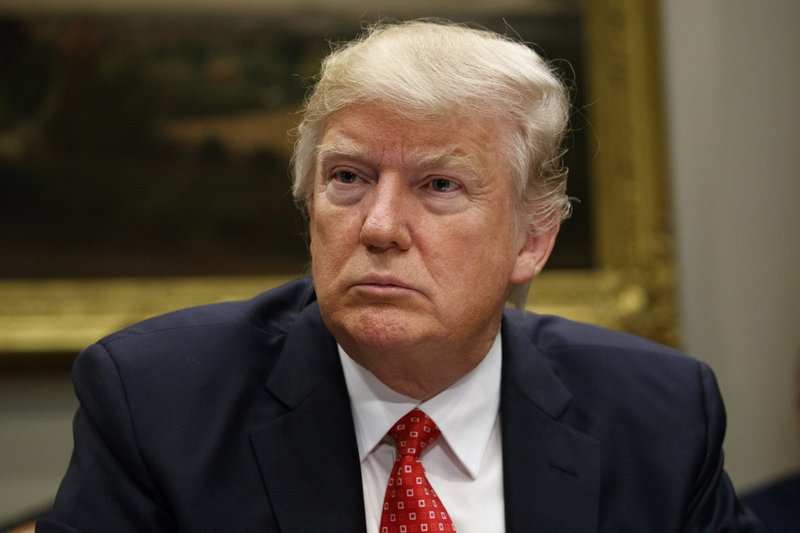

In [17]:
img = Image.fromarray(plt.imread('img.jpg'))
img

In [22]:
output = deep_dream(img, 5, 5, 0.3, 2, 20)

-------------- Recursive level:  0 --------------


RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

-------------- Recursive level:  0 --------------
-------------- Recursive level:  1 --------------
-------------- Recursive level:  2 --------------
-------------- Recursive level:  3 --------------
-------------- Recursive level:  4 --------------
-------------- Recursive level:  5 --------------


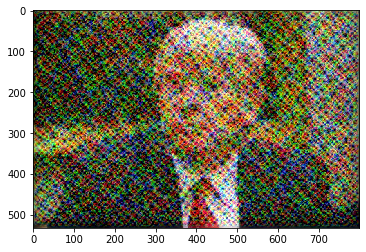

In [30]:
output = deep_dream(img, 10, 10, 0.2, 2, 5)

In [ ]:
#can you implement one class probability optimization to make model dream about bananas
<YOUR CODE>

# Bonus 2: Adversarial Attack

Original PyTorch tutorial is [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)

In [ ]:
# Change the Deep Dream step function
# to make it doing adversarial example from original image


def dd_helper_modified(image, layer, iterations, lr):
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), requires_grad=True, dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):  # maybe change this
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data # and probably this
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img_adv = dd_helper(img, ?, ?, ?)
img_adv

In [ ]:
predict(resize(np.asarray(img_adv), (299, 299)))